In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Initial Inspection


#### example dataset looks like

In [ ]:
df = pd.read_csv('../data/mimedb_microbes_v1.csv')

print("Original dataset shape:", df.shape)
print("Superkingdom value counts:")
print(df['superkingdom'].value_counts())

df = df[df["superkingdom"] == "Bacteria"]
df.head()

Original dataset shape: (2174, 39)
Superkingdom value counts:
superkingdom
Bacteria     1842
Eukaryota     252
Archaea        58
Viruses        22
Name: count, dtype: int64


#### Dataset information

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1842 entries, 0 to 2166
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1842 non-null   int64  
 1   name                 1842 non-null   object 
 2   microbe_id           1842 non-null   object 
 3   species              1664 non-null   object 
 4   kingdom              0 non-null      object 
 5   phylum               1842 non-null   object 
 6   ncbi_tax_id          1842 non-null   int64  
 7   activity             45 non-null     object 
 8   gram                 898 non-null    object 
 9   oxygen_requirement   1457 non-null   object 
 10  created_at           1842 non-null   object 
 11  updated_at           1842 non-null   object 
 12  klass                1841 non-null   object 
 13  order                1841 non-null   object 
 14  family               1834 non-null   object 
 15  genus                1826 non-null   object

#### Summary Statistics (Categorical/Object)

In [19]:
df.describe(include='object')

,name,microbe_id,species,kingdom,phylum,activity,gram,oxygen_requirement,created_at,updated_at,...,flagella_presence,temperature_range,habitat,biotic_relationship,cell_arrangement,sporulation,energy_source,superkingdom,data_source,genome_ids
count,1842,1842,1664,0,1842,45,898,1457,1842,1842,...,276,311,313,305,224,249,75,1842,52,1842
unique,1842,1842,936,0,19,2,6,19,1842,1842,...,4,2,9,2,24,21,6,1,1,1842
top,Ureaplasma urealyticum serovar 8 str. ATCC 27618,MMDBm0815403,Escherichia coli,NaN,Firmicutes,Production (export),Positive,Anaerobe,2021-02-12 11:46:21.810734,2022-08-25 23:58:19.224594,...,No,Mesophilic,HostAssociated,Free living,Singles,Pairs - Singles,Chemoorganotroph,Bacteria,NJS16,732
freq,1,1,35,NaN,755,43,457,580,1,1,...,153,309,165,287,49,46,42,1842,52,1


#### Summary Statistics (Numerical):

In [20]:
df.describe()

,id,ncbi_tax_id,number_of_membranes,optimal_temperature,background,health_type,evidence_type,export,human_pathogen,parent_id,level
count,1842.000000,1.842000e+03,292.000000,145.000000,0.0,0.0,0.0,1842.0,63.0,0.0,0.0
mean,289700.741585,3.928037e+05,1.438356,32.606897,NaN,NaN,NaN,1.0,1.0,NaN,NaN
std,328334.412780,4.046888e+05,0.497037,6.836683,NaN,NaN,NaN,0.0,0.0,NaN,NaN
min,2.000000,7.000000e+00,1.000000,0.000000,NaN,NaN,NaN,1.0,1.0,NaN,NaN
25%,726.500000,3.191700e+04,1.000000,30.000000,NaN,NaN,NaN,1.0,1.0,NaN,NaN
50%,2495.500000,3.002680e+05,1.000000,37.000000,NaN,NaN,NaN,1.0,1.0,NaN,NaN
75%,637967.250000,5.729922e+05,2.000000,37.000000,NaN,NaN,NaN,1.0,1.0,NaN,NaN
max,815403.000000,2.382124e+06,2.000000,45.000000,NaN,NaN,NaN,1.0,1.0,NaN,NaN


#### Data shape

In [21]:
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset shape: 1842 rows, 39 columns


## 2. Missing Value Analysis


Missing values per column (sorted):
                     Missing Count  Missing Percent
kingdom                       1842       100.000000
evidence_type                 1842       100.000000
background                    1842       100.000000
level                         1842       100.000000
parent_id                     1842       100.000000
health_type                   1842       100.000000
activity                      1797        97.557003
data_source                   1790        97.176982
human_pathogen                1779        96.579805
energy_source                 1767        95.928339
optimal_temperature           1697        92.128122
cell_arrangement              1618        87.839305
sporulation                   1593        86.482085
flagella_presence             1566        85.016287
number_of_membranes           1550        84.147666
mobility                      1538        83.496200
biotic_relationship           1537        83.441911
temperature_range          

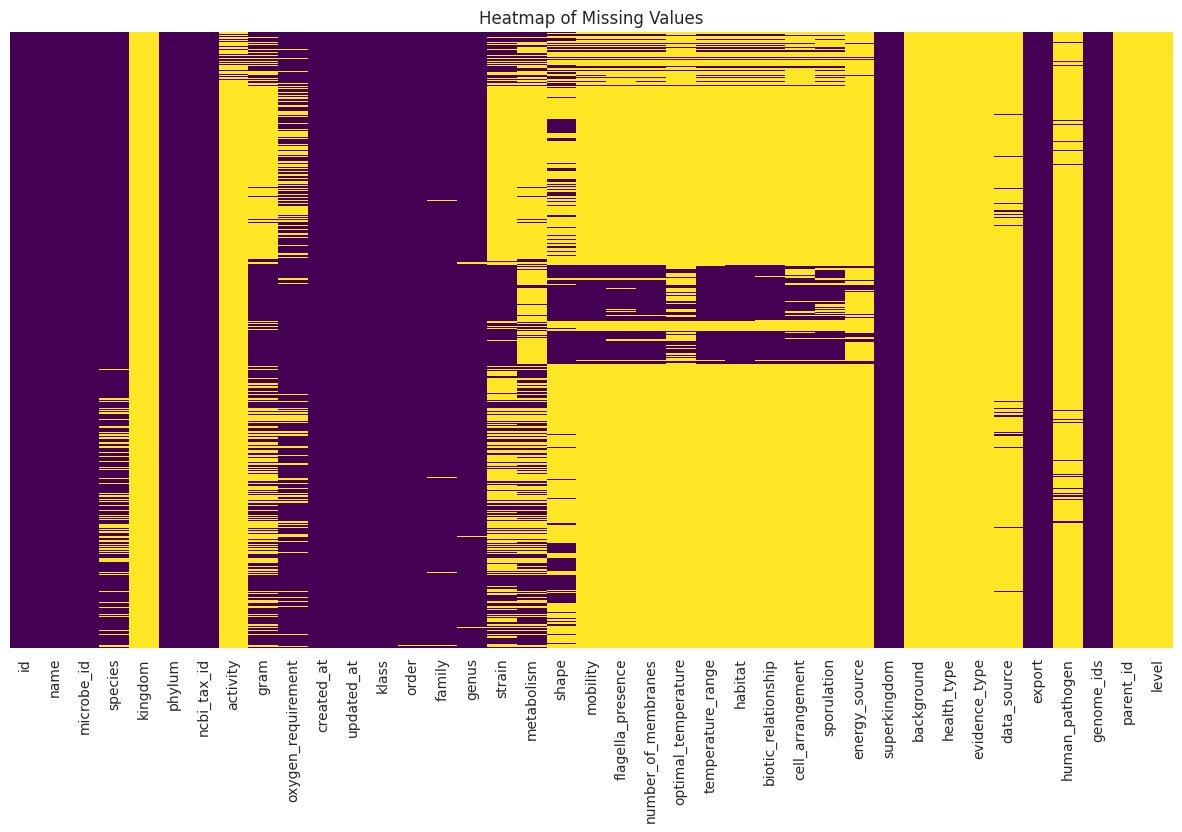

In [22]:
missing_values_count = df.isnull().sum()

missing_values_percent = (missing_values_count / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing Percent': missing_values_percent
}).sort_values(by='Missing Percent', ascending=False)

print("\nMissing values per column (sorted):")
print(missing_info)

plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

### Analisis Missing Value dan Implikasinya

Dataset ini punya lumayan banyak nilai yang hilang pada berbagai feature. Berikut adalah hasil analisis kami:

1.  **Feature dengan Missing Value Sangat Tinggi atau Total:**
    *   Beberapa kolom seperti `parent_id`, `evidence_type`, `background`, `level`, `health_type`, `data_source`, dan `activity` hampir seluruhnya kosong. Artinya kolom-kolom ini kemungkinan besar tidak akan memberikan kontribusi signifikan ke model dan dapat feature ini dapat**dihapus**.

2.  **Feature Fisiologis, Ekologis, dan Morfologis dengan Kehilangan Data Tinggi:**
    *   Banyak feature yang mendeskripsikan karakteristik mikroba (misalnya, `optimal_temperature`, `metabolism`, `shape`, `sporulation`, `energy_source`, `habitat`) punya persentase kehilangan data yang tinggi (umumnya di atas 70%), dimana missing data pada feature-feature ini akan menyulitkan penggunaannya, sehingga diperlukan strategi untuk imputasi lebih hati-hati, karena mungkin feature tersebut masih sangat diperlukan. Namun untuk feature kategorikal dapat diperlakukan sebagai kategori tersendiri ("Tidak Diketahui").

3.  **Missing Value pada Variabel Target (`human_pathogen`):**
    *   **Asumsi:** Nilai yang hilang (`NULL`) pada kolom `human_pathogen` akan **diinterpretasikan sebagai "non-patogen" (untuk selanjutnya akan diencode sebagai 0). Namun dengan adanya asumsi ini berarti kita punya label untuk semua baris, walaupun sebagian besar akan menjadi "non-patogen" berdasarkan asumsi ini yang tentu dapat menyebabkan distribusi agak sangat tidak normal dan berat sebelah, sehingga perlu dilakukan penanganan model dengan memperhatikan hal ini.
  

## 3. Target Variable Analysis

human_pathogen
0    1779
1      63
Name: count, dtype: int64


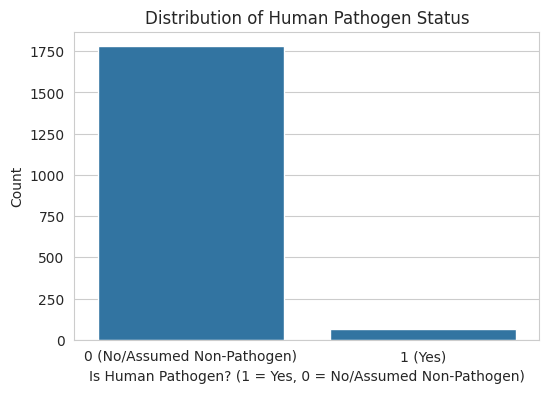

In [23]:

df['human_pathogen'] = df['human_pathogen'].fillna(0.0)

df['human_pathogen'] = df['human_pathogen'].astype(int)

print(df['human_pathogen'].value_counts(dropna=False))


plt.figure(figsize=(6, 4))
sns.countplot(x=df['human_pathogen'])
plt.title('Distribution of Human Pathogen Status')
plt.xlabel('Is Human Pathogen? (1 = Yes, 0 = No/Assumed Non-Pathogen)')
plt.ylabel('Count')
unique_target_values = sorted(df['human_pathogen'].unique())
if set(unique_target_values) == {0, 1}:
    plt.xticks([0, 1], ['0 (No/Assumed Non-Pathogen)', '1 (Yes)'])
elif set(unique_target_values) == {0}:
    plt.xticks([0], ['0 (No/Assumed Non-Pathogen)'])
elif set(unique_target_values) == {1}:
    plt.xticks([1], ['1 (Yes)'])
else:
    print(f"Unexpected unique values in target after processing: {unique_target_values}")
plt.show()

df_target_known = df.copy()


Dari sini kita tahu bahwa asumsi sebelumnya pasti benar dimana NaN value disini berarti memiliki nilai yaitu Non Patogen karena hanya terdapat 2 unique value pada column target dimana patogen berjumlah 64 dan non patogen berjumlah 2110. Cukup menarik disini dimana jumlah bakteri yang non patogen malah justru lebih banyak

## 4. Numerical Feature Analysis

Identified numerical features for EDA: ['number_of_membranes', 'optimal_temperature', 'background', 'health_type', 'evidence_type', 'export']

 Analyzing Numerical Feature: number_of_membranes 
  Number of unique non-null values: 2
  Feature 'number_of_membranes' identified as DISCRETE NUMERICAL (with 2 unique values: [np.float64(1.0), np.float64(2.0)]).


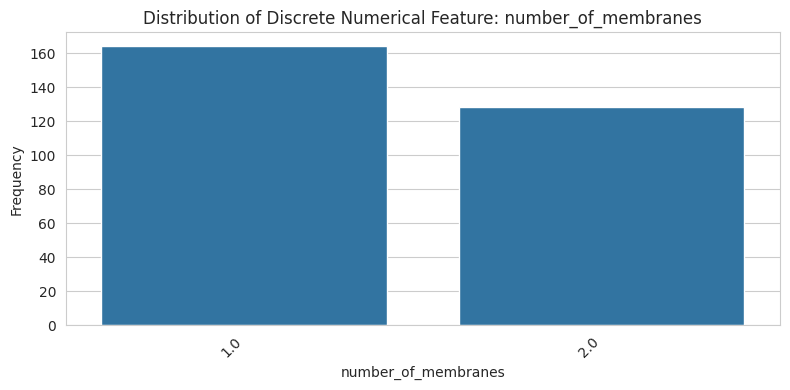

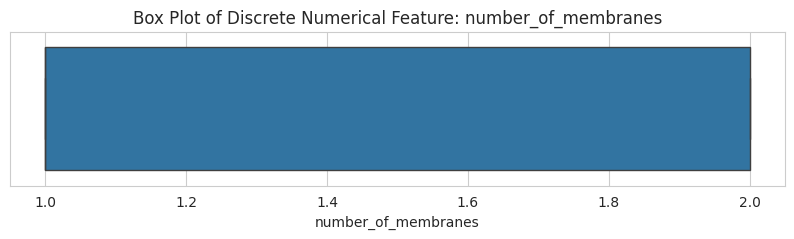


  Summary Statistics for number_of_membranes:
count    292.000000
mean       1.438356
std        0.497037
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: number_of_membranes, dtype: float64
  Interpretation ('number_of_membranes'): Number of cell membranes.

 Analyzing Numerical Feature: optimal_temperature 
  Number of unique non-null values: 14
  Unique values sample (first 5): [np.float64(10.0), np.float64(22.0), np.float64(25.0), np.float64(37.0), np.float64(45.0)]...
  Feature 'optimal_temperature' identified as DISCRETE NUMERICAL (with few unique values).


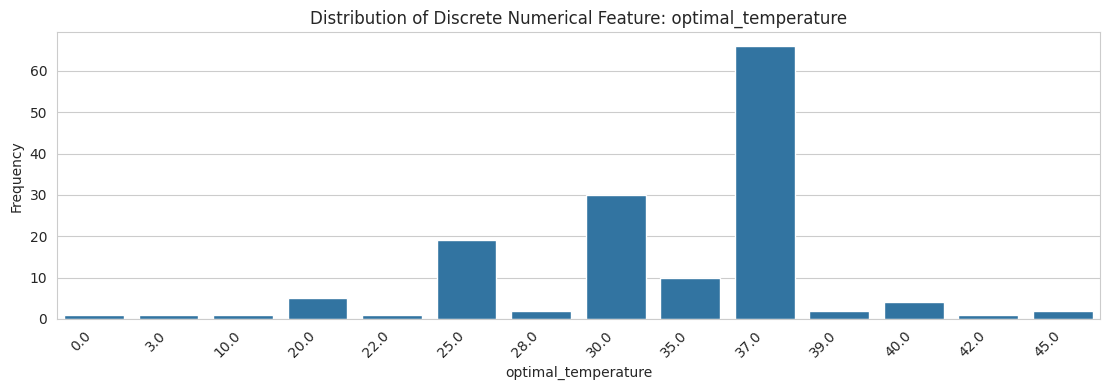

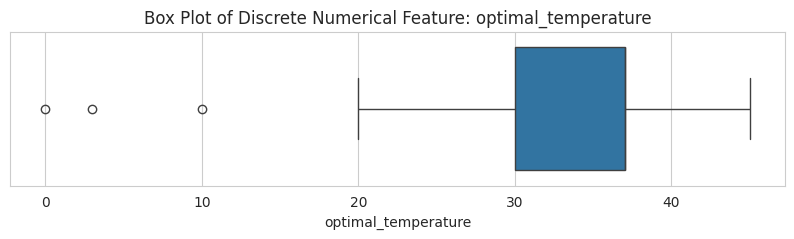


  Summary Statistics for optimal_temperature:
count    145.000000
mean      32.606897
std        6.836683
min        0.000000
25%       30.000000
50%       37.000000
75%       37.000000
max       45.000000
Name: optimal_temperature, dtype: float64
  Interpretation ('optimal_temperature'): Optimal growth temperature.

 Analyzing Numerical Feature: background 
  Feature 'background': All values are NaN. Skipping detailed analysis.

 Analyzing Numerical Feature: health_type 
  Feature 'health_type': All values are NaN. Skipping detailed analysis.

 Analyzing Numerical Feature: evidence_type 
  Feature 'evidence_type': All values are NaN. Skipping detailed analysis.

 Analyzing Numerical Feature: export 
  Number of unique non-null values: 1
  Feature 'export' has only one unique value.


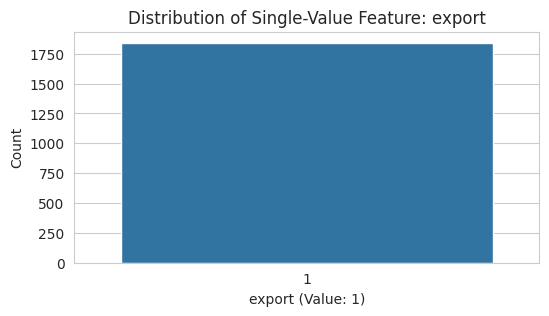


  Summary Statistics for export:
count    1842.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: export, dtype: float64


In [24]:
potential_numerical_features = df.select_dtypes(include=np.number).columns.tolist()

excluded_ids_and_target = ['id', 'ncbi_tax_id', 'parent_id', 'level', 'human_pathogen']
excluded_cols_for_numerical = excluded_ids_and_target + ['genome_ids']

numerical_features_for_eda = [
    col for col in potential_numerical_features if col not in excluded_cols_for_numerical
]

print(f"Identified numerical features for EDA: {numerical_features_for_eda}")

if not numerical_features_for_eda:
    print("No numerical features identified for general analysis (excluding IDs and target).")
else:
    for col in numerical_features_for_eda:
        print(f"\n Analyzing Numerical Feature: {col} ")

        if df[col].isnull().all():
            print(f"  Feature '{col}': All values are NaN. Skipping detailed analysis.")
            continue

        non_null_series = df[col].dropna()
        num_unique_values = non_null_series.nunique()
        unique_values_sample = non_null_series.unique()

        print(f"  Number of unique non-null values: {num_unique_values}")
        if num_unique_values > 2 and num_unique_values <= 10:
            print(f"  Unique values: {sorted(unique_values_sample)}")
        elif num_unique_values > 10:
            print(f"  Unique values sample (first 5): {sorted(unique_values_sample[:5])}...")

        plot_type = None

        if num_unique_values == 0:
            print("  No non-null values to plot.")
            plot_type = "skip"
        elif num_unique_values == 1:
            print(f"  Feature '{col}' has only one unique value.")
            plt.figure(figsize=(6, 3))
            sns.countplot(x=df[col].dropna().astype(str))
            plt.title(f'Distribution of Single-Value Feature: {col}')
            plt.xlabel(f"{col} (Value: {unique_values_sample[0]})")
            plt.ylabel('Count')
            plt.show()
            plot_type = "single_value_countplot"
        elif num_unique_values == 2 and set(unique_values_sample).issubset({0, 1, 0.0, 1.0}):
            print(f"  Feature '{col}' identified as BINARY.")
            plot_type = "binary_countplot"
        elif num_unique_values > 2 and num_unique_values <= 15: # Threshold for "few"
            print(f"  Feature '{col}' identified as DISCRETE NUMERICAL (with few unique values).")
            plot_type = "discrete_countplot"
        else:
            if num_unique_values == 2:
                 print(f"  Feature '{col}' identified as DISCRETE NUMERICAL (with 2 unique values: {sorted(unique_values_sample)}).")
                 plot_type = "discrete_countplot"
            else: # num_unique_values > 15
                 print(f"  Feature '{col}' identified as CONTINUOUS or discrete with many values.")
                 plot_type = "histogram_boxplot"


        if plot_type == "binary_countplot":
            plt.figure(figsize=(6, 4))
            sns.countplot(x=df[col].fillna('Unknown'))
            plt.title(f'Distribution of Binary Feature: {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.show()
            if col == 'export':
                 print("  Interpretation ('export'): Binary flag. Meaning needs clarification.")

        elif plot_type == "discrete_countplot":
            plt.figure(figsize=(max(8, num_unique_values * 0.8), 4))
            order = sorted(unique_values_sample)
            sns.countplot(x=non_null_series, order=order)
            plt.title(f'Distribution of Discrete Numerical Feature: {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            if num_unique_values > 1:
                plt.figure(figsize=(10, 2))
                sns.boxplot(x=non_null_series)
                plt.title(f'Box Plot of Discrete Numerical Feature: {col}')
                plt.xlabel(col)
                plt.show()

        elif plot_type == "histogram_boxplot":
            plt.figure(figsize=(10, 4))
            sns.histplot(non_null_series, kde=True, bins=min(30, num_unique_values))
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()

            plt.figure(figsize=(10, 2))
            sns.boxplot(x=non_null_series)
            plt.title(f'Box Plot of {col}')
            plt.xlabel(col)
            plt.show()

        if plot_type != "skip":
            print(f"\n  Summary Statistics for {col}:")
            print(df[col].describe())

            if col == 'number_of_membranes':
                print("  Interpretation ('number_of_membranes'): Number of cell membranes.")
            elif col == 'optimal_temperature':
                print("  Interpretation ('optimal_temperature'): Optimal growth temperature.")

### Numerical Analysis

*   **`number_of_membranes`**:
    *   Punya nilai 1.0 dan 2.0, sesuai dengan ekspektasi jumlah membran untuk bakteri Gram-positif dan Gram-negatif.

*   **`optimal_temperature`**:
    *   Menunjukkan variasi suhu pertumbuhan optimal (0°C - 85°C), dengan mayoritas mikroba cenderung mesofilik (sekitar 30-37°C). Keberadaan nilai ekstrem mungkin menandakan mikroba ekstremofilik.

*   **`background`, `health_type`, `evidence_type`**:
    *   Ketiga fitur ini sepenuhnya kosong (semua nilai NaN). Tidak kasih informasi dan kemungkinan akan dihilangkan.

*   **`export`**:
    *   Semua entri yang punya data untuk fitur ini bernilai 1.0. Ini menunjukkan sebuah *flag* dengan status sama pada data yang terisi, sehingga kurang informatif dengan jumlahnya sebanyak row data yang berarti feature ini juga bisa dihilankan.

## 5. Categorical Feature Analysis

Identified categorical features for EDA (primarily object type): ['kingdom', 'phylum', 'activity', 'gram', 'oxygen_requirement', 'klass', 'order', 'family', 'genus', 'metabolism', 'shape', 'mobility', 'flagella_presence', 'temperature_range', 'habitat', 'biotic_relationship', 'cell_arrangement', 'sporulation', 'energy_source', 'superkingdom', 'data_source']

 Analysis of General Categorical Features 

 Analyzing Categorical Feature: kingdom 
  Feature 'kingdom': All values are NaN. Skipping.

 Analyzing Categorical Feature: phylum 
  Number of unique values (including NaN if present): 19
  High cardinality (19 unique values). Showing top 10 most frequent categories:
phylum
Firmicutes        755
Proteobacteria    540
Actinobacteria    228
Bacteroidetes     208
Fusobacteria       34
Tenericutes        31
Spirochaetes       13
Chlamydiae          7
Synergistetes       6
Chlorobi            4
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


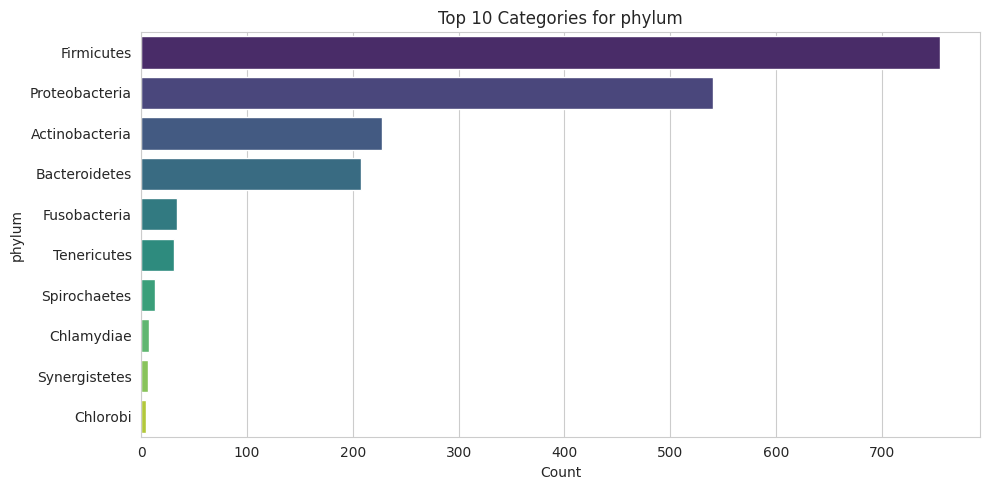


 Analyzing Categorical Feature: activity 
  Number of unique values (including NaN if present): 3


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


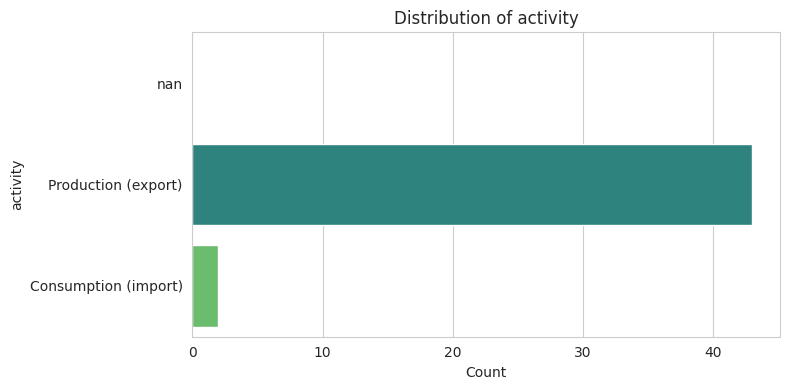


 Analyzing Categorical Feature: gram 
  Number of unique values (including NaN if present): 7


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


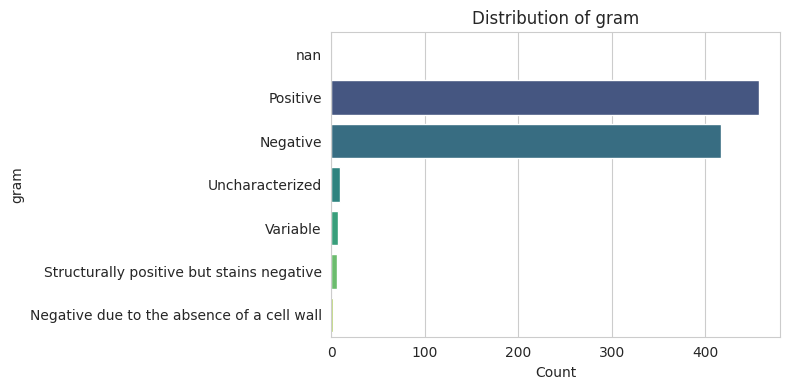

/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")



 Analyzing Categorical Feature: oxygen_requirement 
  Number of unique values (including NaN if present): 20
  High cardinality (20 unique values). Showing top 10 most frequent categories:
oxygen_requirement
Anaerobe                        580
Facultative anaerobe            538
NaN                             385
Aerobe                          238
Microaerophile                   25
Microaerophilic                  22
Facultative aerobe               18
Aerobe; facultative anaerobe      7
Obligate anaerobe                 7
Aerobe; anaerobe                  6
Name: count, dtype: int64


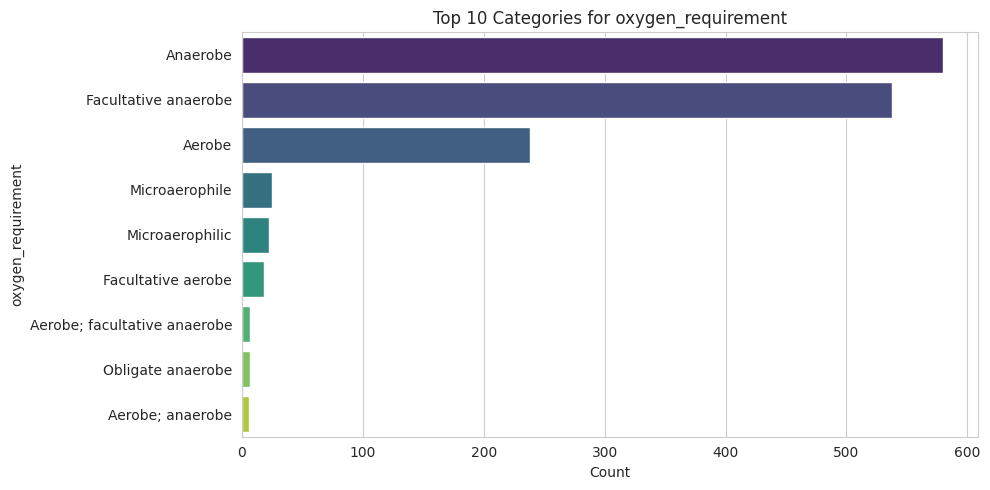


 Analyzing Categorical Feature: klass 
  Number of unique values (including NaN if present): 40
  High cardinality (40 unique values). Showing top 10 most frequent categories:
klass
Bacilli                  429
Gammaproteobacteria      304
Clostridia               237
Actinobacteria           201
Bacteroidia              191
Betaproteobacteria        78
Alphaproteobacteria       72
Epsilonproteobacteria     55
Erysipelotrichia          36
Negativicutes             35
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


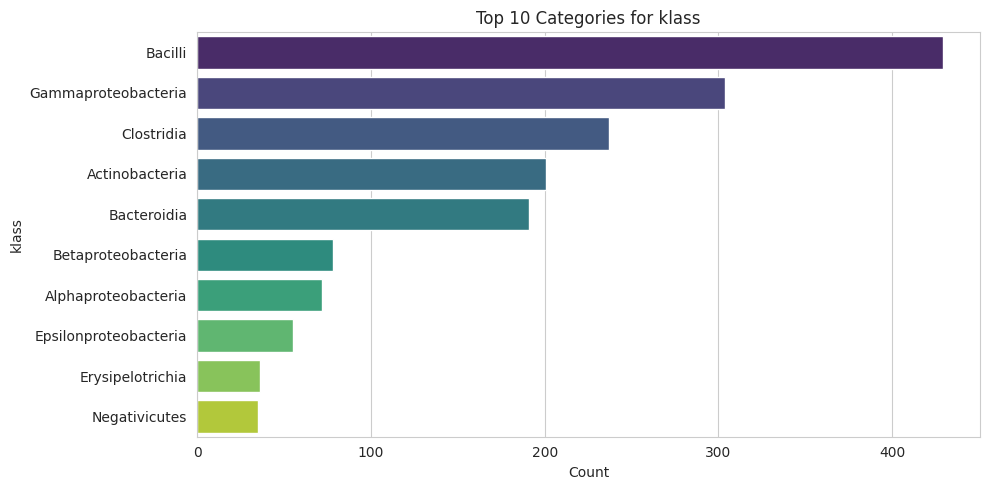


 Analyzing Categorical Feature: order 
  Number of unique values (including NaN if present): 87
  High cardinality (87 unique values). Showing top 10 most frequent categories:
order
Lactobacillales      243
Clostridiales        232
Bacteroidales        191
Bacillales           186
Enterobacteriales     93
Enterobacterales      81
Actinomycetales       67
Bifidobacteriales     61
Pseudomonadales       56
Campylobacterales     54
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


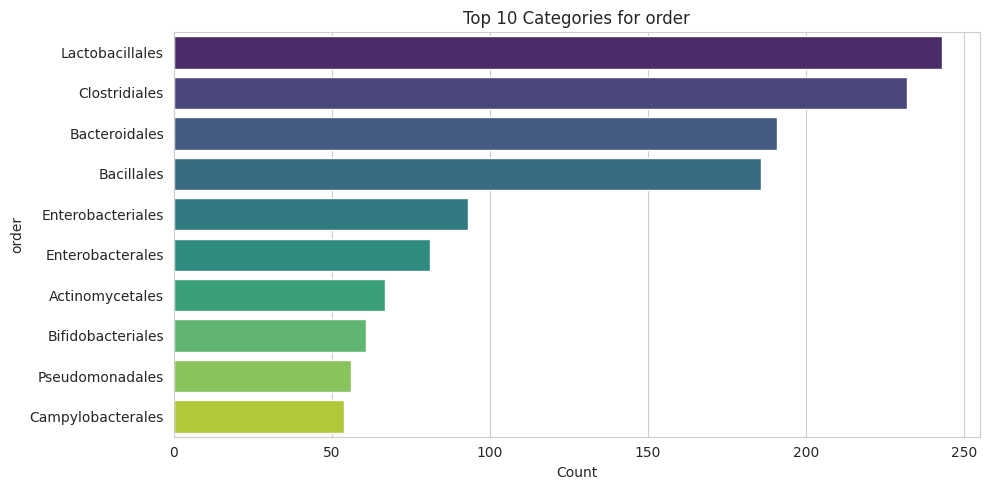


 Analyzing Categorical Feature: family 
  Number of unique values (including NaN if present): 171
  High cardinality (171 unique values). Showing top 10 most frequent categories:
family
Enterobacteriaceae    141
Streptococcaceae      103
Lachnospiraceae        87
Lactobacillaceae       86
Bacteroidaceae         78
Bacillaceae            77
Prevotellaceae         65
Bifidobacteriaceae     61
Clostridiaceae         57
Staphylococcaceae      56
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


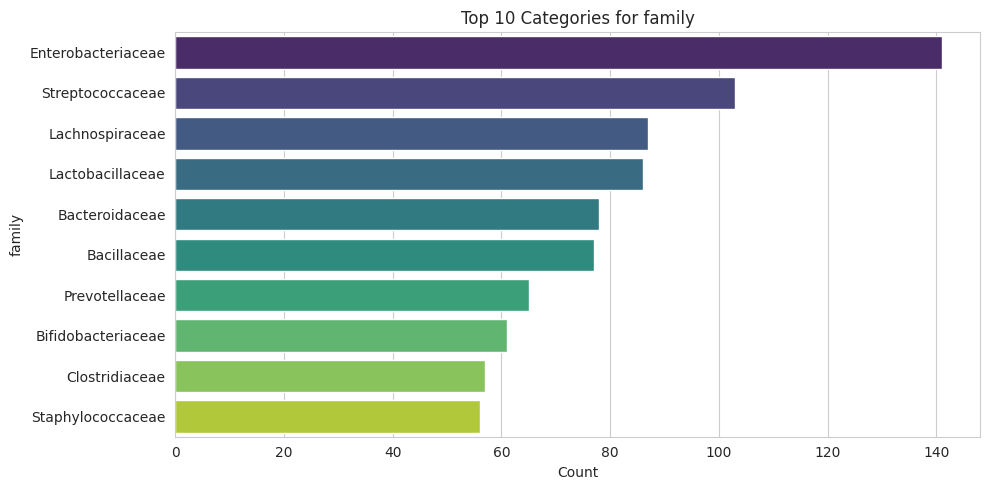


 Analyzing Categorical Feature: genus 
  Number of unique values (including NaN if present): 373
  High cardinality (373 unique values). Showing top 10 most frequent categories:
genus
Streptococcus      95
Lactobacillus      78
Bacteroides        70
Bacillus           64
Prevotella         59
Bifidobacterium    58
Staphylococcus     54
Clostridium        53
Escherichia        42
Campylobacter      32
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


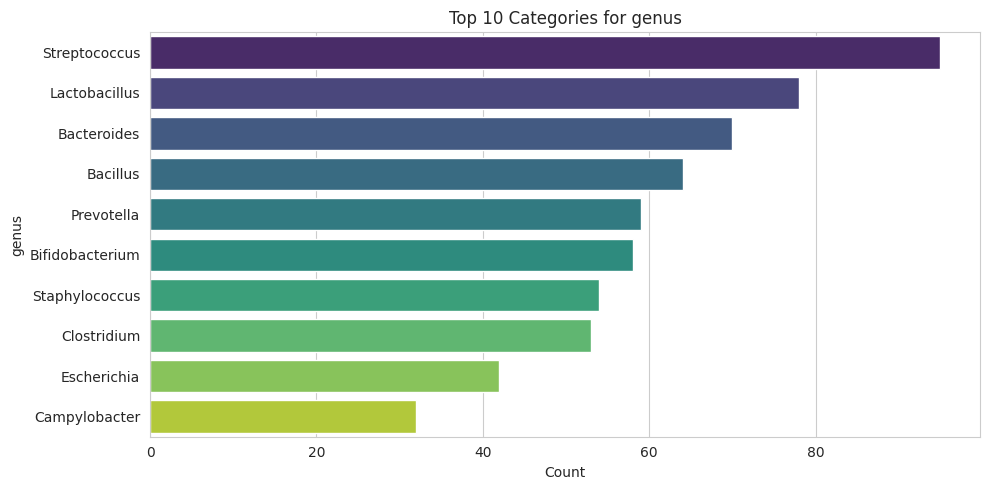


 Analyzing Categorical Feature: metabolism 
  Number of unique values (including NaN if present): 77
  High cardinality (77 unique values). Showing top 10 most frequent categories:
metabolism
NaN                                                                                  1217
Saccharolytic, fermentative                                                           259
Saccharolytic, respiratory or fermentative                                             75
Respiratory                                                                            32
Fermentative, respiratory                                                              24
Respiration or fermentation of carbohydrates and central metabolism intermediates      20
Saccharolytic                                                                          18
Saccharolytic, proteolytic, fermentative                                               16
Saccharolytic, fermentative or respiratory                                             

/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


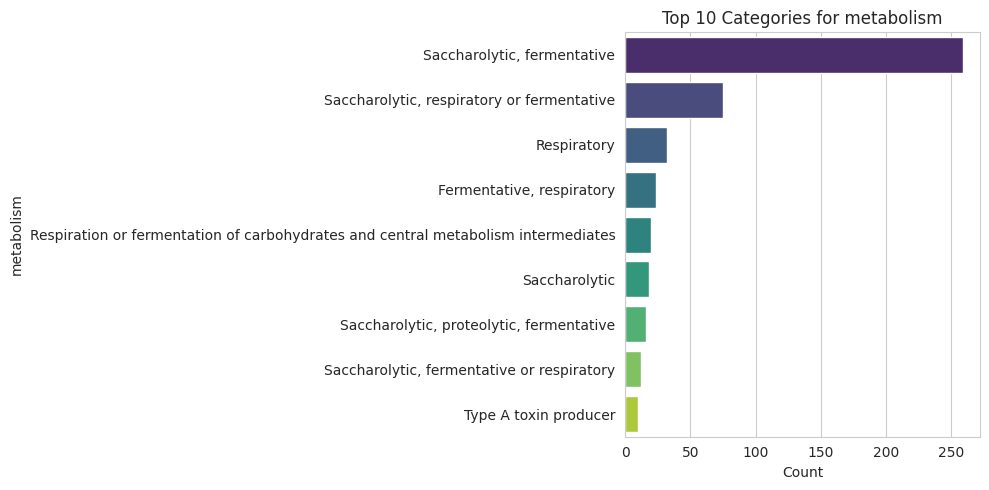


 Analyzing Categorical Feature: shape 
  Number of unique values (including NaN if present): 5


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


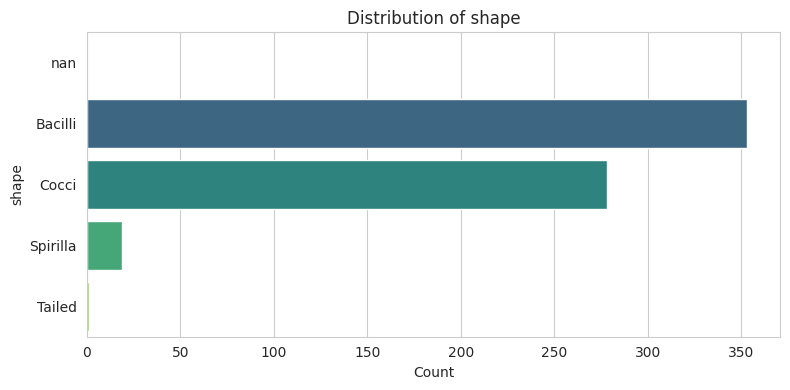


 Analyzing Categorical Feature: mobility 
  Number of unique values (including NaN if present): 3


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


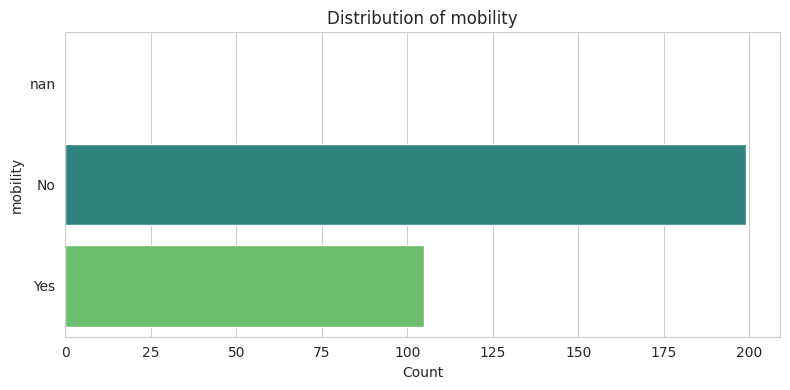


 Analyzing Categorical Feature: flagella_presence 
  Number of unique values (including NaN if present): 5


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


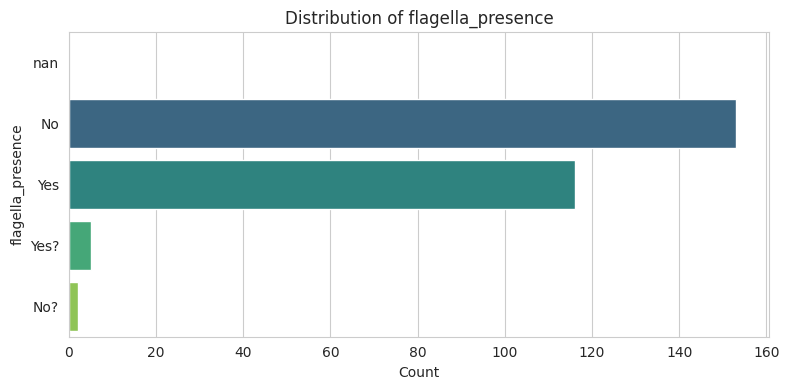


 Analyzing Categorical Feature: temperature_range 
  Number of unique values (including NaN if present): 3


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


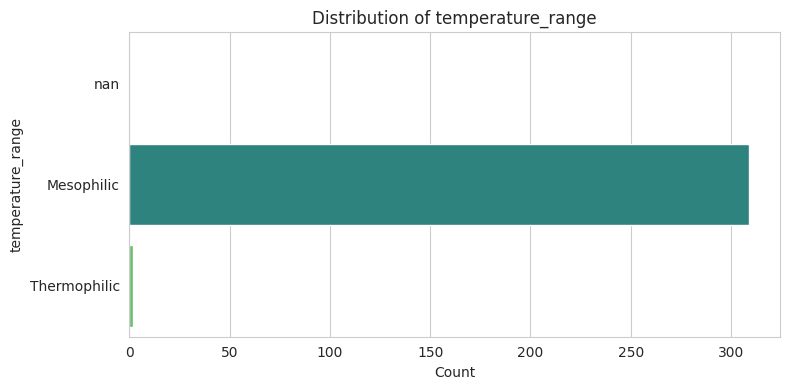


 Analyzing Categorical Feature: habitat 
  Number of unique values (including NaN if present): 10


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


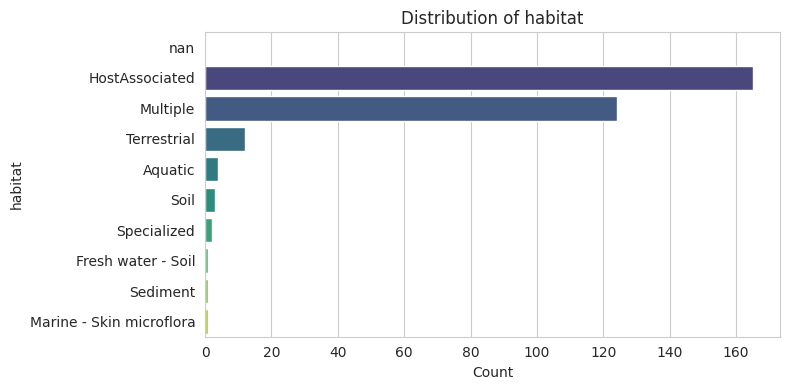


 Analyzing Categorical Feature: biotic_relationship 
  Number of unique values (including NaN if present): 3


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


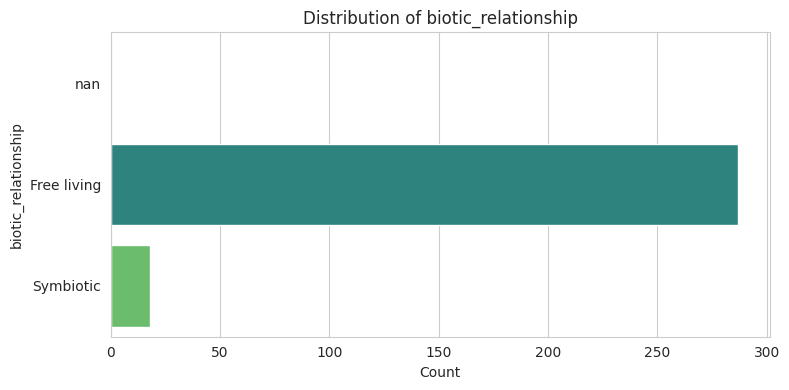


 Analyzing Categorical Feature: cell_arrangement 
  Number of unique values (including NaN if present): 25
  High cardinality (25 unique values). Showing top 10 most frequent categories:
cell_arrangement
NaN                         1618
Singles                       49
Pairs - Singles               46
Chains - Pairs                30
Chains                        16
Chains - Singles              15
Clusters - Singles            14
Pairs - Singles - Chains      11
Chains - Pairs - Singles       9
Pairs - Chains                 6
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


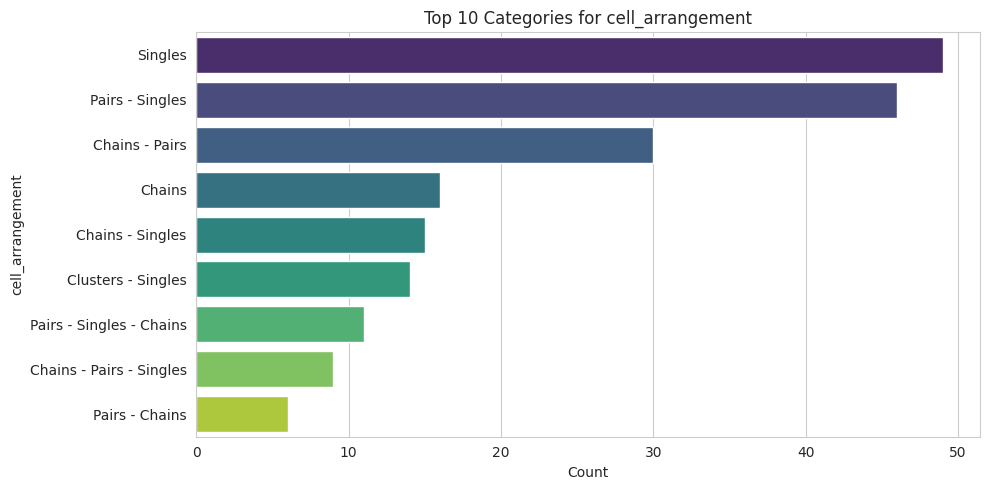


 Analyzing Categorical Feature: sporulation 
  Number of unique values (including NaN if present): 22
  High cardinality (22 unique values). Showing top 10 most frequent categories:
sporulation
NaN                         1593
Pairs - Singles               46
Singles                       40
Nonsporulating                34
Chains - Pairs                30
Sporulating                   23
Chains - Singles              14
Clusters - Singles            14
Pairs - Singles - Chains      11
Pairs - Chains                 6
Name: count, dtype: int64


/tmp/ipykernel_17539/2105607583.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")


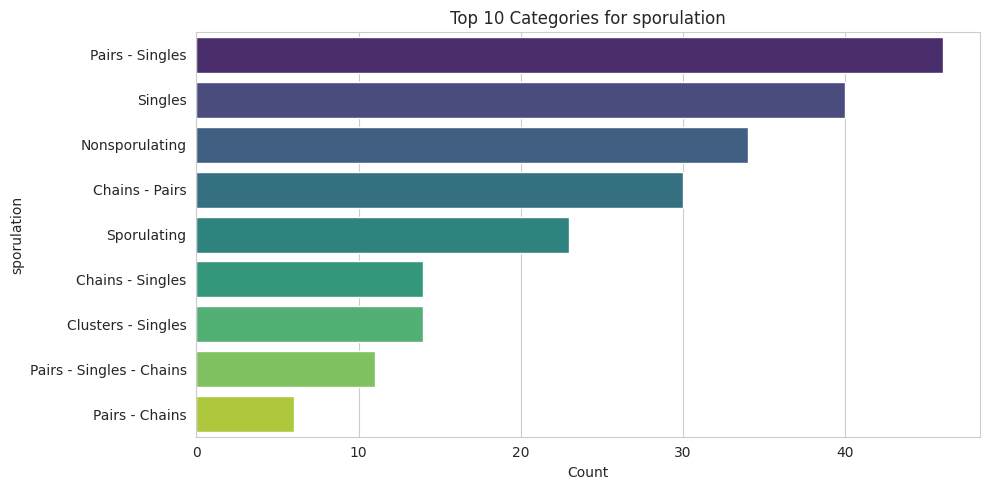


 Analyzing Categorical Feature: energy_source 
  Number of unique values (including NaN if present): 7


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


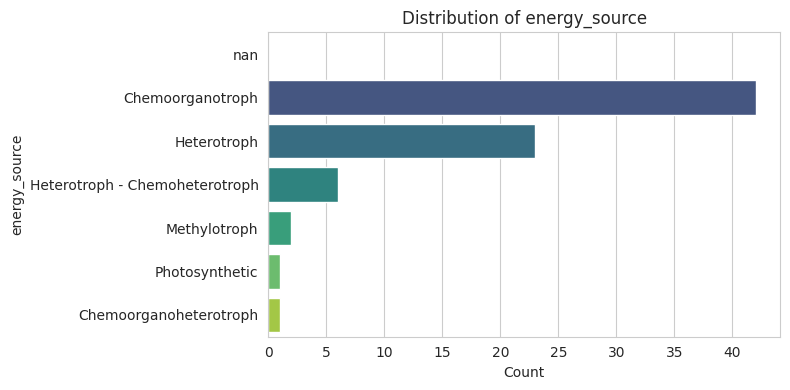


 Analyzing Categorical Feature: superkingdom 
  Number of unique values (including NaN if present): 1
  Only one non-NaN value: 'Bacteria'.


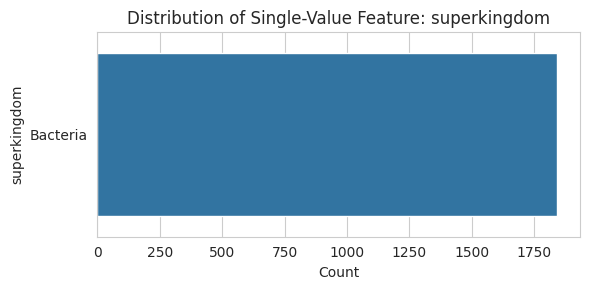


 Analyzing Categorical Feature: data_source 
  Number of unique values (including NaN if present): 2


/tmp/ipykernel_17539/2105607583.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette="viridis")


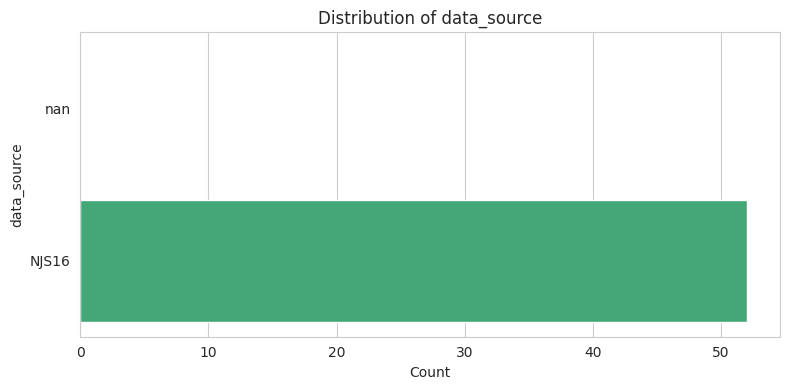

In [25]:
potential_categorical_object_type = df.select_dtypes(include=['object']).columns.tolist()

excluded_cols_from_categorical_plotting = [
    'id', 'microbe_id', 'name', 'strain', 'species',
    'created_at', 'updated_at',
    'human_pathogen',
    "genome_ids"
]

categorical_features_for_eda = [
    col for col in potential_categorical_object_type if col not in excluded_cols_from_categorical_plotting
]

print(f"Identified categorical features for EDA (primarily object type): {categorical_features_for_eda}")
print("\n Analysis of General Categorical Features ")
high_cardinality_plot_threshold = 10

if not categorical_features_for_eda:
    print("No general categorical features identified for plotting distributions.")
else:
    for col in categorical_features_for_eda:
        print(f"\n Analyzing Categorical Feature: {col} ")

        if df[col].isnull().all():
            print(f"  Feature '{col}': All values are NaN. Skipping.")
            continue

        num_unique_values = df[col].nunique(dropna=False)
        print(f"  Number of unique values (including NaN if present): {num_unique_values}")

        if num_unique_values == 1:
            value = df[col].dropna().unique()
            if len(value) > 0:
                 print(f"  Only one non-NaN value: '{value[0]}'.")
                 plt.figure(figsize=(6,3))
                 sns.countplot(y=df[col].dropna())
                 plt.title(f'Distribution of Single-Value Feature: {col}')
                 plt.xlabel('Count')
                 plt.ylabel(col)
                 plt.tight_layout()
                 plt.show()
            else:
                 print("  Only NaN values present.")

        elif num_unique_values > high_cardinality_plot_threshold:
            print(f"  High cardinality ({num_unique_values} unique values). Showing top 10 most frequent categories:")
            print(df[col].value_counts(dropna=False).nlargest(10))
            plt.figure(figsize=(10, 5))
            top_n_plot = df[col].value_counts(dropna=False).nlargest(10)
            sns.barplot(x=top_n_plot.values, y=top_n_plot.index, palette="viridis", orient="h")
            plt.title(f'Top 10 Categories for {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
        elif num_unique_values > 0 :
            plt.figure(figsize=(max(8, num_unique_values * 0.6), max(4, num_unique_values * 0.3)))
            order = df[col].value_counts(dropna=False).index
            sns.countplot(data=df, y=col, order=order, palette="viridis")
            plt.title(f'Distribution of {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
        else:
            print("  No values to plot (all NaN).")

### Categorical Analysis


**Karakteristik Taksonomi Umum:**

*   **`kingdom`**: Ada 7 kategori kingdom yang berbeda.
*   **`phylum`**: Dari 37 filum yang ada, Firmicutes (755 entri) dan Proteobacteria (540 entri) adalah yang paling dominan.
*   **`klass`**: Pada tingkat kelas (80 variasi), Bacilli (429 entri) dan Gammaproteobacteria (304 entri) adalah yang paling banyak.
*   **`order`**: Tingkat ordo (159 variasi) didominasi oleh Lactobacillales (243 entri) dan Clostridiales (232 entri).
*   **`family`**: Tingkat famili (299 variasi) paling banyak diwakili oleh Enterobacteriaceae (141 entri) dan Streptococcaceae (103 entri).
*   **`genus`**: Tingkat genus (561 variasi) menunjukkan Streptococcus (95 entri) dan Lactobacillus (78 entri) sebagai yang paling umum. Ada 39 entri tanpa informasi genus (NaN).
*   **`superkingdom`**: Ada 4 kategori superkingdom yang teridentifikasi.

**Karakteristik Fisiologis dan Morfologis:**

*   **`activity`**: Hanya 3 jenis aktivitas fungsional yang teridentifikasi.
*   **`gram`**: Ada 7 variasi input untuk hasil pewarnaan Gram (mungkin termasuk NaN atau kategori lain).
*   **`oxygen_requirement`**: Dari 20 variasi kebutuhan oksigen, sebagian besar entri tidak memiliki informasi ini (NaN: 705 entri), diikuti oleh Anaerobe (588 entri) dan Facultative anaerobe (538 entri).
*   **`metabolism`**: Ada 82 tipe metabolisme yang berbeda, namun mayoritas entri (1542) tidak memiliki informasi metabolisme (NaN). "Saccharolytic, fermentative" adalah tipe yang paling umum teridentifikasi setelah NaN.
*   **`shape`**: Bentuk sel mikroba dikategorikan dalam 5 variasi.
*   **`mobility`**: Kemampuan bergerak mikroba terbagi dalam 3 kategori.
*   **`flagella_presence`**: Adanya flagela (terkait mobilitas) teridentifikasi dalam 5 variasi input.
*   **`cell_arrangement`**: Pola susunan sel (26 variasi), dengan sebagian besar entri tidak memiliki informasi ini (NaN: 1946 entri). "Singles" adalah susunan yang paling umum teridentifikasi setelah NaN.
*   **`sporulation`**: Kemampuan membentuk spora (22 variasi input), juga didominasi oleh nilai NaN (1924 entri).
*   **`energy_source`**: Sumber energi utama mikroba dikelompokkan dalam 8 variasi.

**Karakteristik Lingkungan dan Interaksi:**

*   **`temperature_range`**: Preferensi rentang suhu hidup dikategorikan dalam 4 variasi.
*   **`habitat`**: Lingkungan utama tempat mikroba ditemukan teridentifikasi dalam 10 variasi.
*   **`biotic_relationship`**: Jenis interaksi dengan organisme lain terbagi dalam 3 kategori.


## 6. Correlation Feature to Target

Analyzing correlations for 1842 rows.
Distribution of target 'human_pathogen' for this analysis:
human_pathogen
0    96.579805
1     3.420195
Name: proportion, dtype: float64

Relationship between Numerical Features and Human Pathogen status:

  Analysis for Numerical Feature: number_of_membranes


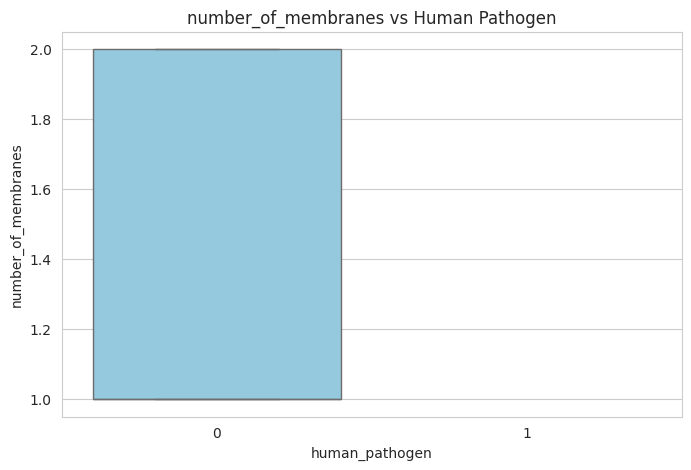

    Mean number_of_membranes by pathogen status:
human_pathogen
0    1.438356
1         NaN
Name: number_of_membranes, dtype: float64
    Std Dev number_of_membranes by pathogen status:
human_pathogen
0    0.497037
1         NaN
Name: number_of_membranes, dtype: float64

  Analysis for Numerical Feature: optimal_temperature


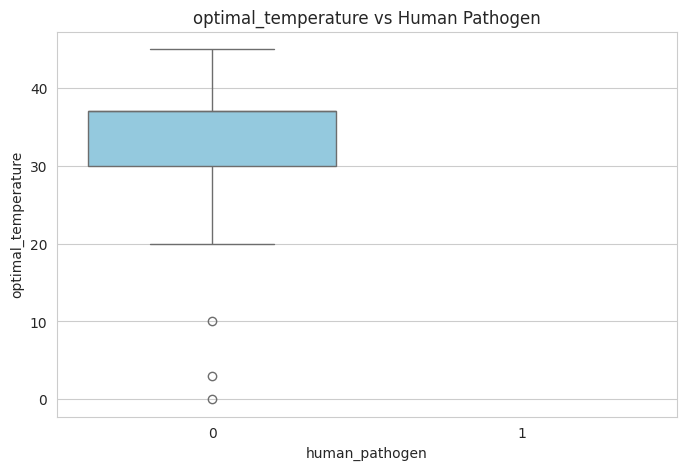

    Mean optimal_temperature by pathogen status:
human_pathogen
0    32.606897
1          NaN
Name: optimal_temperature, dtype: float64
    Std Dev optimal_temperature by pathogen status:
human_pathogen
0    6.836683
1         NaN
Name: optimal_temperature, dtype: float64
  Feature 'background' doesn't exist in analysis data or all values are NaN.
  Feature 'health_type' doesn't exist in analysis data or all values are NaN.
  Feature 'evidence_type' doesn't exist in analysis data or all values are NaN.

  Analysis for Numerical Feature: export


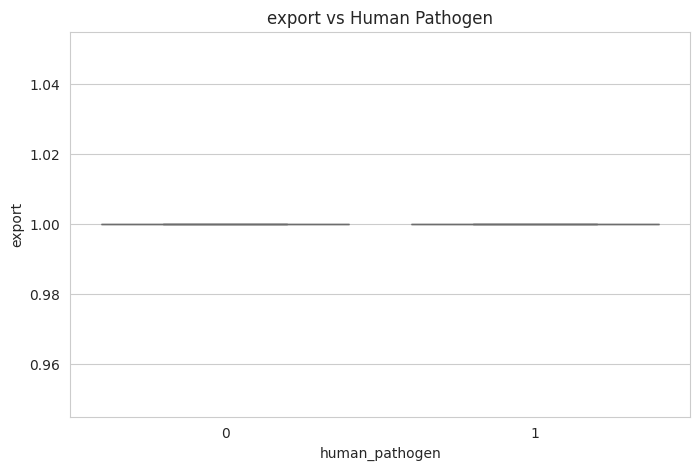

    Mean export by pathogen status:
human_pathogen
0    1.0
1    1.0
Name: export, dtype: float64
    Std Dev export by pathogen status:
human_pathogen
0    0.0
1    0.0
Name: export, dtype: float64

Relationship between Categorical Features and Human Pathogen status:
  Feature 'kingdom' doesn't exist in analysis data or all values are NaN.

  Analysis for Categorical Feature: phylum (19 unique non-NaN categories)
  Feature 'phylum': High cardinality (19 unique categories). Countplot skipped.
    Contingency table for top 10 categories of 'phylum':
human_pathogen  0 (Non-Pathogen)  1 (Pathogen)
phylum                                        
Actinobacteria         97.368421      2.631579
Bacteroidetes          99.519231      0.480769
Chlamydiae             57.142857     42.857143
Chlorobi              100.000000      0.000000
Firmicutes             98.013245      1.986755
Fusobacteria          100.000000      0.000000
Proteobacteria         94.814815      5.185185
Spirochaetes          

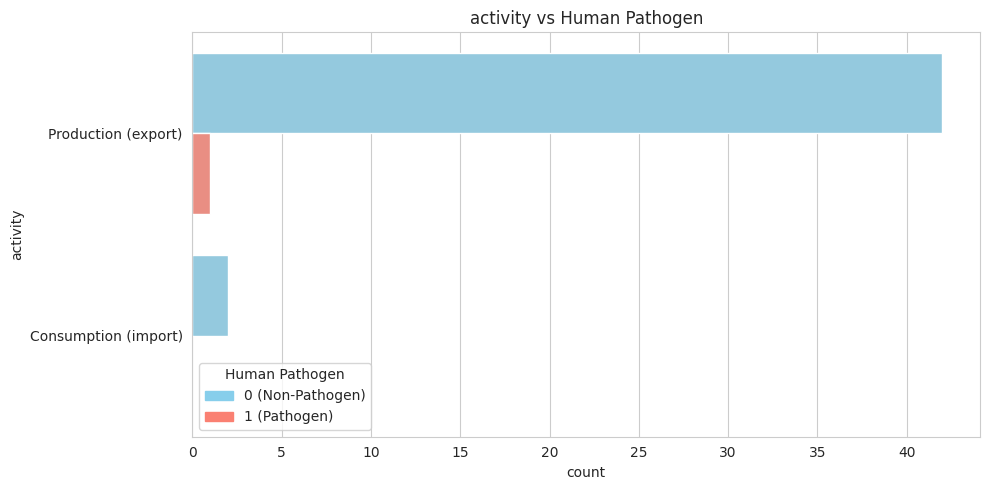

    Percentage of Pathogen/Non-Pathogen for each category in 'activity':
human_pathogen        0 (Non-Pathogen)  1 (Pathogen)
activity                                            
Consumption (import)        100.000000      0.000000
Production (export)          97.674419      2.325581

  Analysis for Categorical Feature: gram (6 unique non-NaN categories)


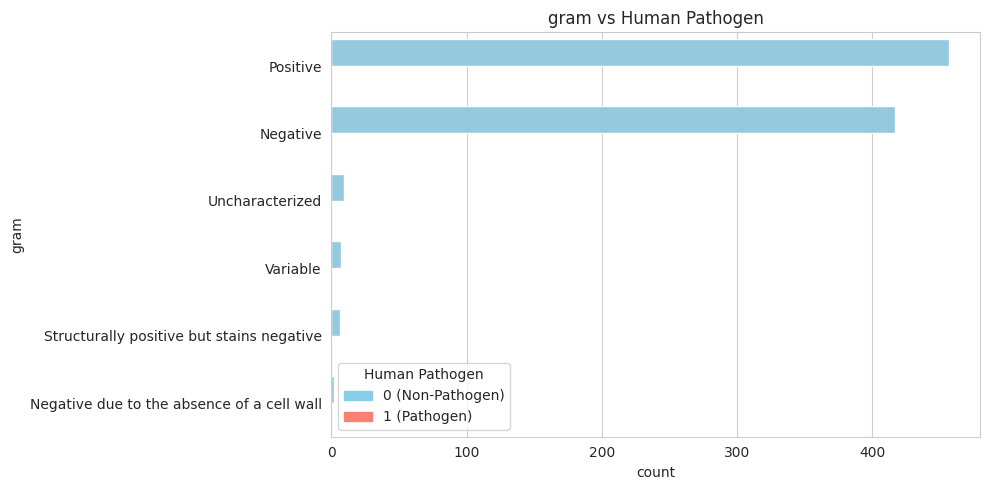

    Percentage of Pathogen/Non-Pathogen for each category in 'gram':
human_pathogen                              0 (Non-Pathogen)  1 (Pathogen)
gram                                                                      
Negative                                               100.0           0.0
Negative due to the absence of a cell wall             100.0           0.0
Positive                                               100.0           0.0
Structurally positive but stains negative              100.0           0.0
Uncharacterized                                        100.0           0.0
Variable                                               100.0           0.0

  Analysis for Categorical Feature: oxygen_requirement (19 unique non-NaN categories)
  Feature 'oxygen_requirement': High cardinality (19 unique categories). Countplot skipped.
    Contingency table for top 10 categories of 'oxygen_requirement':
human_pathogen                0 (Non-Pathogen)  1 (Pathogen)
oxygen_requirement    

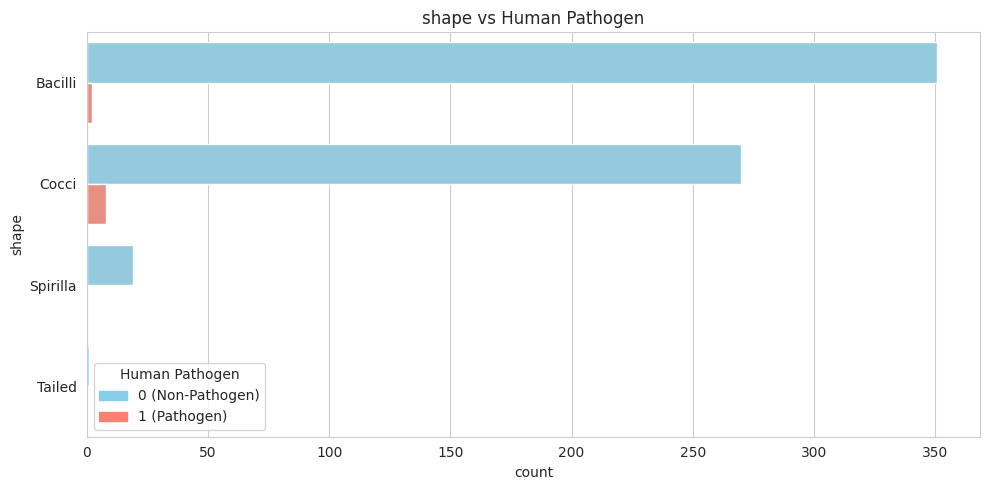

    Percentage of Pathogen/Non-Pathogen for each category in 'shape':
human_pathogen  0 (Non-Pathogen)  1 (Pathogen)
shape                                         
Bacilli                99.433428      0.566572
Cocci                  97.122302      2.877698
Spirilla              100.000000      0.000000
Tailed                100.000000      0.000000

  Analysis for Categorical Feature: mobility (2 unique non-NaN categories)


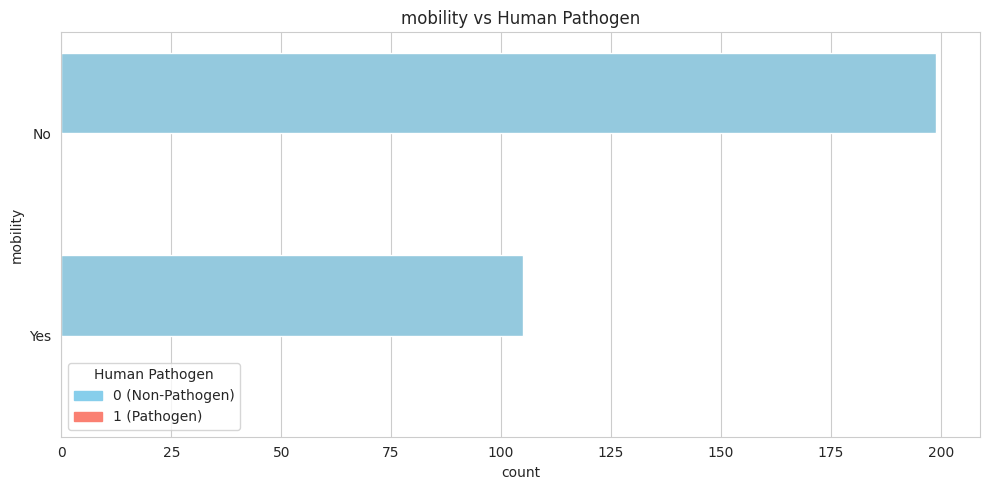

    Percentage of Pathogen/Non-Pathogen for each category in 'mobility':
human_pathogen  0 (Non-Pathogen)  1 (Pathogen)
mobility                                      
No                         100.0           0.0
Yes                        100.0           0.0

  Analysis for Categorical Feature: flagella_presence (4 unique non-NaN categories)


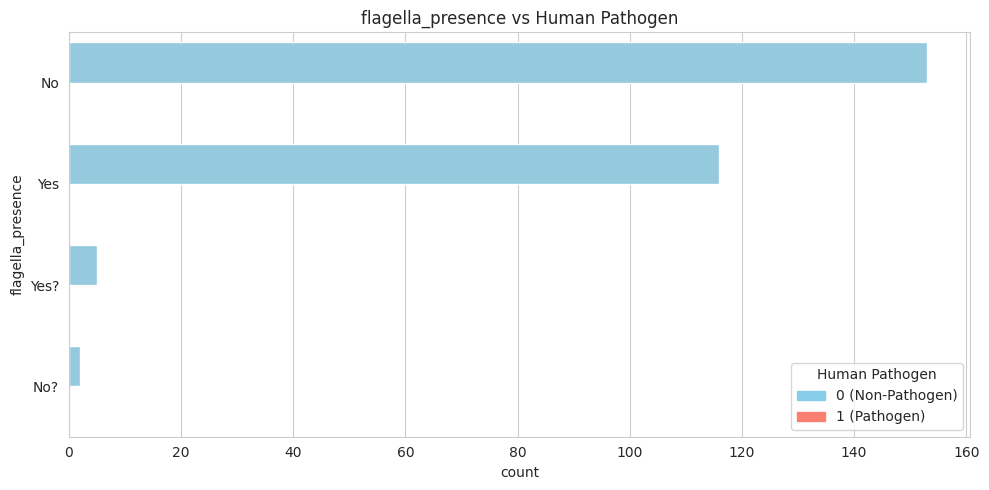

    Percentage of Pathogen/Non-Pathogen for each category in 'flagella_presence':
human_pathogen     0 (Non-Pathogen)  1 (Pathogen)
flagella_presence                                
No                            100.0           0.0
No?                           100.0           0.0
Yes                           100.0           0.0
Yes?                          100.0           0.0

  Analysis for Categorical Feature: temperature_range (2 unique non-NaN categories)


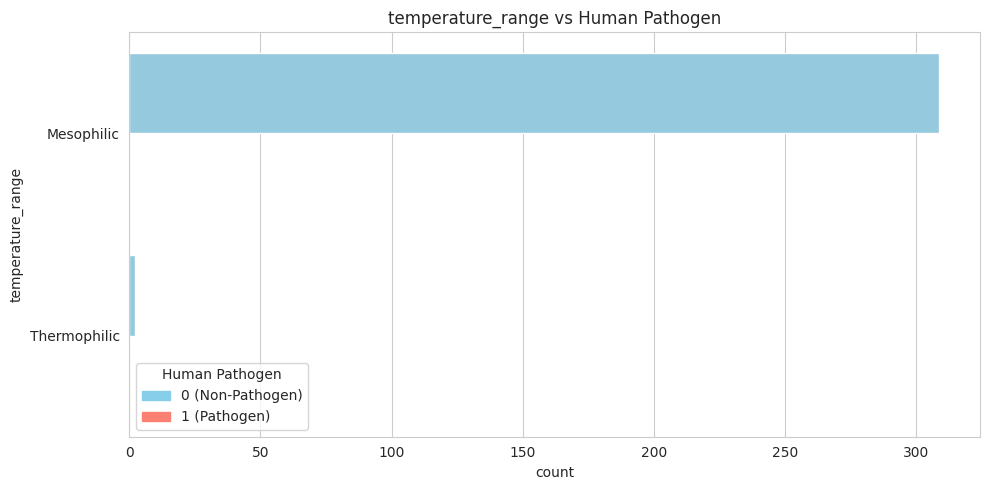

    Percentage of Pathogen/Non-Pathogen for each category in 'temperature_range':
human_pathogen     0 (Non-Pathogen)  1 (Pathogen)
temperature_range                                
Mesophilic                    100.0           0.0
Thermophilic                  100.0           0.0

  Analysis for Categorical Feature: habitat (9 unique non-NaN categories)


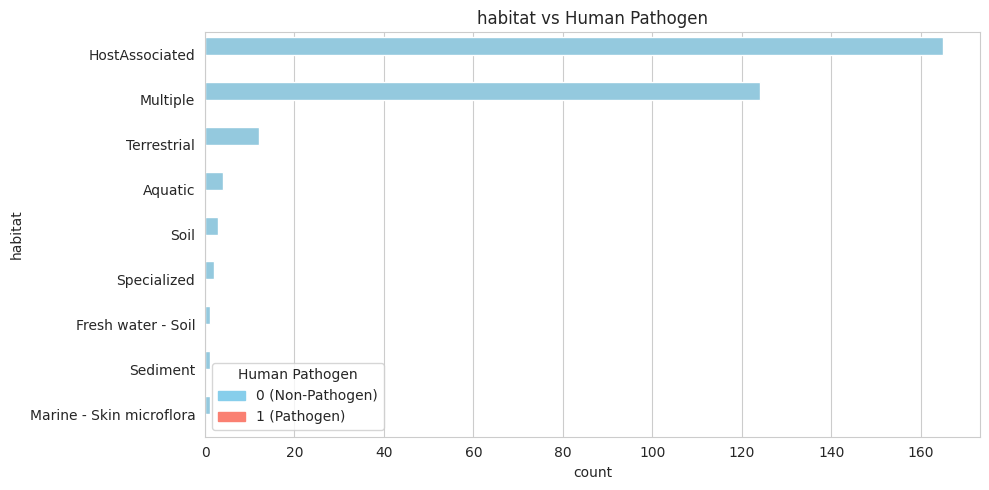

    Percentage of Pathogen/Non-Pathogen for each category in 'habitat':
human_pathogen            0 (Non-Pathogen)  1 (Pathogen)
habitat                                                 
Aquatic                              100.0           0.0
Fresh water - Soil                   100.0           0.0
HostAssociated                       100.0           0.0
Marine - Skin microflora             100.0           0.0
Multiple                             100.0           0.0
Sediment                             100.0           0.0
Soil                                 100.0           0.0
Specialized                          100.0           0.0
Terrestrial                          100.0           0.0

  Analysis for Categorical Feature: biotic_relationship (2 unique non-NaN categories)


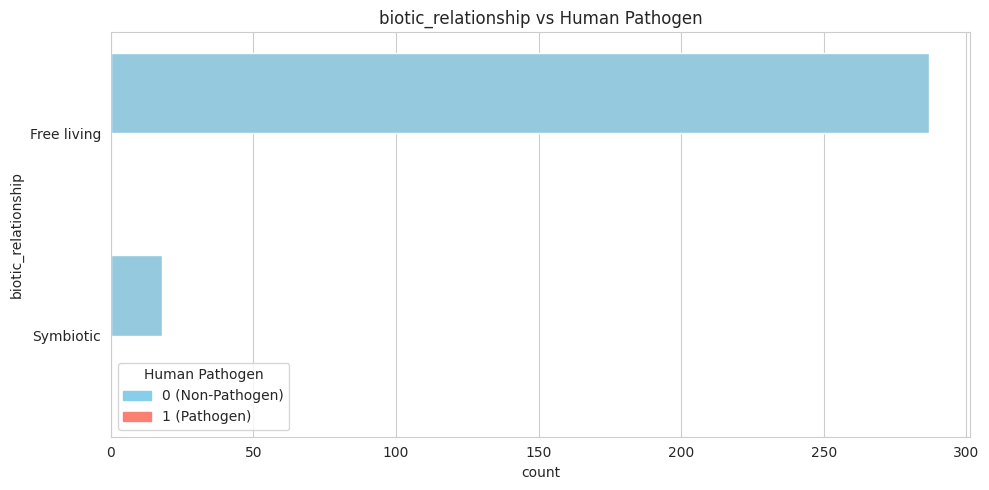

    Percentage of Pathogen/Non-Pathogen for each category in 'biotic_relationship':
human_pathogen       0 (Non-Pathogen)  1 (Pathogen)
biotic_relationship                                
Free living                     100.0           0.0
Symbiotic                       100.0           0.0

  Analysis for Categorical Feature: cell_arrangement (24 unique non-NaN categories)
  Feature 'cell_arrangement': High cardinality (24 unique categories). Countplot skipped.
    Contingency table for top 10 categories of 'cell_arrangement':
human_pathogen              0 (Non-Pathogen)  1 (Pathogen)
cell_arrangement                                          
Chains                                 100.0           0.0
Chains - Pairs                         100.0           0.0
Chains - Pairs - Singles               100.0           0.0
Chains - Singles                       100.0           0.0
Clusters - Pairs - Singles             100.0           0.0
Clusters - Singles                     100.0         

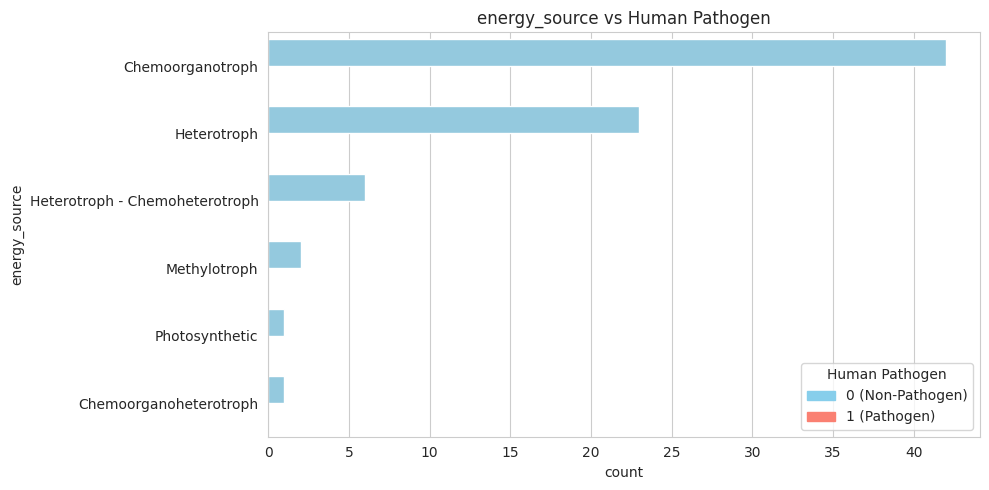

    Percentage of Pathogen/Non-Pathogen for each category in 'energy_source':
human_pathogen                  0 (Non-Pathogen)  1 (Pathogen)
energy_source                                                 
Chemoorganoheterotroph                     100.0           0.0
Chemoorganotroph                           100.0           0.0
Heterotroph                                100.0           0.0
Heterotroph - Chemoheterotroph             100.0           0.0
Methylotroph                               100.0           0.0
Photosynthetic                             100.0           0.0

  Analysis for Categorical Feature: superkingdom (1 unique non-NaN categories)


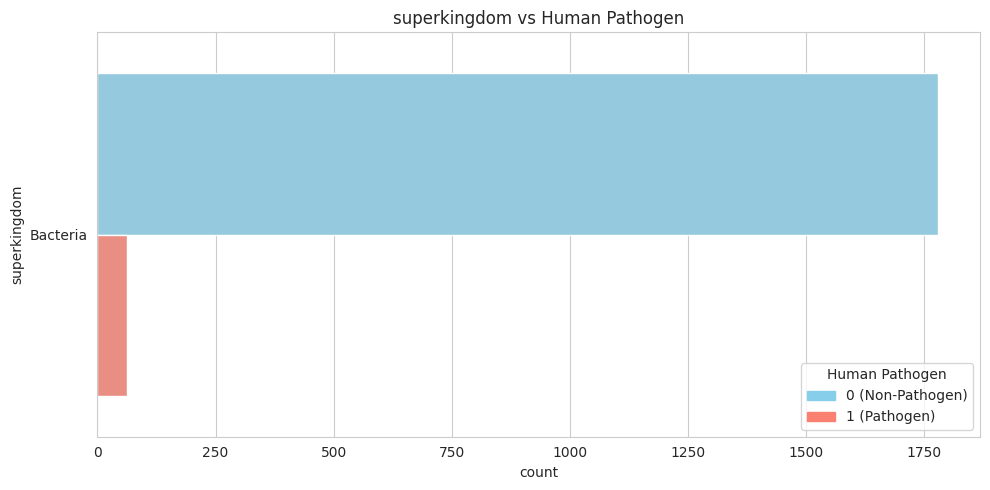

    Percentage of Pathogen/Non-Pathogen for each category in 'superkingdom':
human_pathogen  0 (Non-Pathogen)  1 (Pathogen)
superkingdom                                  
Bacteria               96.579805      3.420195

  Analysis for Categorical Feature: data_source (1 unique non-NaN categories)


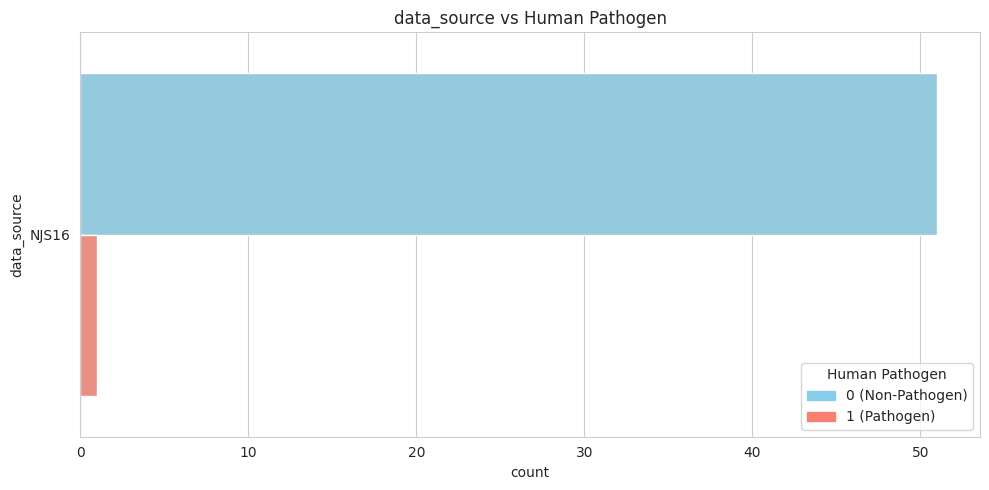

    Percentage of Pathogen/Non-Pathogen for each category in 'data_source':
human_pathogen  0 (Non-Pathogen)  1 (Pathogen)
data_source                                   
NJS16                  98.076923      1.923077


In [26]:
df_corr_analysis = pd.DataFrame()

if 'human_pathogen' not in df.columns:
    print("ERROR: Column 'human_pathogen' not found. Target correlation analysis cannot continue.")
    print("ERROR: Column 'human_pathogen' contains all NaN values. Cannot perform correlation analysis.")
else:
    df_corr_analysis = df.copy()

    if df_corr_analysis['human_pathogen'].isnull().any():
        print("INFO: Filling NaN in 'human_pathogen' with 0.0 for df_corr_analysis.")
        df_corr_analysis['human_pathogen'] = df_corr_analysis['human_pathogen'].fillna(0.0)

    if pd.api.types.is_float_dtype(df_corr_analysis['human_pathogen']) and \
       not df_corr_analysis['human_pathogen'].isinf().any() and \
       not df_corr_analysis['human_pathogen'].isnull().any():
        print("INFO: Converting 'human_pathogen' in df_corr_analysis to integer type.")
        df_corr_analysis['human_pathogen'] = df_corr_analysis['human_pathogen'].astype(int)
    elif not pd.api.types.is_integer_dtype(df_corr_analysis['human_pathogen']):
        print(f"WARNING: 'human_pathogen' in df_corr_analysis cannot be converted to int or is not a clean float. Current type: {df_corr_analysis['human_pathogen'].dtype}")
        print(f"Unique values of 'human_pathogen' before trying to plot: {df_corr_analysis['human_pathogen'].unique()}")


defined_palette = {0: "skyblue", 1: "salmon"}


if df_corr_analysis.empty or 'human_pathogen' not in df_corr_analysis.columns:
    print("No valid data for correlation analysis with target.")
elif not pd.api.types.is_integer_dtype(df_corr_analysis['human_pathogen']) or \
     df_corr_analysis['human_pathogen'].nunique(dropna=True) < 1 :
    print(f"Target variable 'human_pathogen' is not valid for bivariate analysis (type: {df_corr_analysis['human_pathogen'].dtype}, "
          f"unique non-NaN values: {df_corr_analysis['human_pathogen'].dropna().unique()}). Must be integer and have at least 1 unique non-NaN value.")
elif df_corr_analysis['human_pathogen'].nunique(dropna=True) < 2 and len(df_corr_analysis['human_pathogen'].dropna().unique()) > 0:
     print(f"Target variable 'human_pathogen' has only one unique non-NaN value: {df_corr_analysis['human_pathogen'].dropna().unique()[0]}. "
           "Bivariate analysis may not be informative.")
else:
    print(f"Analyzing correlations for {len(df_corr_analysis)} rows.")
    print(f"Distribution of target 'human_pathogen' for this analysis:\n{df_corr_analysis['human_pathogen'].value_counts(normalize=True) * 100}")

    print("\nRelationship between Numerical Features and Human Pathogen status:")
    if 'numerical_features_for_eda' not in locals():
        numerical_features_for_eda = []

    if not numerical_features_for_eda:
        print("  The 'numerical_features_for_eda' list is empty. Skipping numerical vs target analysis.")
    else:
        for col in numerical_features_for_eda:
            if col in df_corr_analysis.columns and df_corr_analysis[col].notnull().any():
                if df_corr_analysis[col].nunique(dropna=True) < 1:
                    print(f"  Feature '{col}' has no non-NaN values. Boxplot cannot be created.")
                    continue

                print(f"\n  Analysis for Numerical Feature: {col}")
                plt.figure(figsize=(8, 5))

                actual_target_values_for_plot = sorted(df_corr_analysis['human_pathogen'].dropna().unique())
                palette_to_use_boxplot = {
                    k_int: v_color for k_int, v_color in defined_palette.items()
                    if k_int in actual_target_values_for_plot
                }

                if len(actual_target_values_for_plot) < 2:
                    print(f"    Plotting {col} without hue coloring because target has only one unique non-NaN value.")
                    sns.boxplot(x='human_pathogen', y=col, data=df_corr_analysis)
                elif not palette_to_use_boxplot:
                     print(f"    Plotting {col} without custom palette because target values don't match defined palette or target is not diverse.")
                     sns.boxplot(x='human_pathogen', y=col, data=df_corr_analysis, hue='human_pathogen', legend=False)
                else:
                    sns.boxplot(x='human_pathogen', y=col, data=df_corr_analysis,
                                hue='human_pathogen', palette=palette_to_use_boxplot, legend=False)

                plt.title(f'{col} vs Human Pathogen')
                int_ticks = [int(val) for val in actual_target_values_for_plot if isinstance(val, (int, float)) and not np.isnan(val)]
                str_labels = [f"{val} ({'Pathogen' if val == 1 else 'Non-Pathogen'})" for val in int_ticks]
                if int_ticks:
                    plt.xticks(ticks=int_ticks, labels=str_labels)
                plt.show()

                if pd.api.types.is_numeric_dtype(df_corr_analysis[col]):
                    try:
                        mean_by_pathogen = df_corr_analysis.groupby('human_pathogen')[col].mean()
                        std_by_pathogen = df_corr_analysis.groupby('human_pathogen')[col].std()
                        print(f"    Mean {col} by pathogen status:\n{mean_by_pathogen}")
                        print(f"    Std Dev {col} by pathogen status:\n{std_by_pathogen}")
                    except Exception as e:
                        print(f"    Cannot calculate mean for {col}: {e}")
                else:
                    print(f"    Column {col} is not numeric (after dropna), skipping mean comparison.")
            else:
                print(f"  Feature '{col}' doesn't exist in analysis data or all values are NaN.")

    print("\nRelationship between Categorical Features and Human Pathogen status:")
    if 'categorical_features_for_eda' not in locals():
        categorical_features_for_eda = []
    if 'high_cardinality_plot_threshold' not in locals():
        high_cardinality_plot_threshold = 30


    if not categorical_features_for_eda:
        print("  The 'categorical_features_for_eda' list is empty. Skipping categorical vs target analysis.")
    else:
        for col in categorical_features_for_eda:
            if col in df_corr_analysis.columns and df_corr_analysis[col].notnull().any():
                num_unique_cats = df_corr_analysis[col].nunique(dropna=True)

                if num_unique_cats == 0:
                    print(f"  Feature '{col}': All values are NaN in analysis subset. Skipping.")
                    continue

                print(f"\n  Analysis for Categorical Feature: {col} ({num_unique_cats} unique non-NaN categories)")

                actual_target_values_for_plot_cat = sorted(df_corr_analysis['human_pathogen'].dropna().unique())
                palette_to_use_countplot = {
                    k_int: v_color for k_int, v_color in defined_palette.items()
                    if k_int in actual_target_values_for_plot_cat
                }
                legend_labels_cat = {
                    k_int: f"{k_int} ({'Pathogen' if k_int == 1 else 'Non-Pathogen'})"
                    for k_int in actual_target_values_for_plot_cat
                }

                if num_unique_cats > high_cardinality_plot_threshold:
                    print(f"  Feature '{col}': High cardinality ({num_unique_cats} unique categories). Countplot skipped.")
                    top_n_categories = df_corr_analysis[col].value_counts(dropna=True).nlargest(10).index
                    subset_for_crosstab = df_corr_analysis[df_corr_analysis[col].isin(top_n_categories)]
                    if not subset_for_crosstab.empty and subset_for_crosstab['human_pathogen'].notna().any():
                        try:
                            contingency_table = pd.crosstab(subset_for_crosstab[col], subset_for_crosstab['human_pathogen'], normalize='index') * 100
                            contingency_table = contingency_table.rename(columns=legend_labels_cat)
                            ordered_cols = [legend_labels_cat[val] for val in actual_target_values_for_plot_cat if val in legend_labels_cat]
                            for expected_label in ordered_cols:
                                if expected_label not in contingency_table.columns:
                                    contingency_table[expected_label] = 0.0
                            print(f"    Contingency table for top 10 categories of '{col}':")
                            print(contingency_table[ordered_cols])
                        except Exception as e:
                            print(f"      Cannot create contingency table for {col}: {e}")
                    else:
                        print(f"      No valid data (or all target NaN) for top 10 categories of '{col}'.")
                    continue


                plt.figure(figsize=(max(10, num_unique_cats * 0.7), 5))
                cat_order = df_corr_analysis[col].value_counts(dropna=True).index

                if len(actual_target_values_for_plot_cat) < 2:
                    print(f"    Plotting {col} without hue coloring because target has only one unique non-NaN value.")
                    sns.countplot(data=df_corr_analysis, y=col, order=cat_order)
                elif not palette_to_use_countplot:
                    print(f"    Plotting {col} without custom palette because target values don't match palette.")
                    sns.countplot(data=df_corr_analysis, y=col, hue='human_pathogen', order=cat_order, dodge=True)
                else:
                    sns.countplot(data=df_corr_analysis, y=col, hue='human_pathogen', order=cat_order, palette=palette_to_use_countplot, dodge=True)

                plt.title(f'{col} vs Human Pathogen')
                if palette_to_use_countplot and legend_labels_cat and len(actual_target_values_for_plot_cat) >=1:
                    valid_legend_keys = [k for k in actual_target_values_for_plot_cat if k in palette_to_use_countplot]
                    handles = [plt.Rectangle((0,0),1,1, color=palette_to_use_countplot[val]) for val in valid_legend_keys]
                    labels = [legend_labels_cat[val] for val in valid_legend_keys]
                    if handles:
                         plt.legend(title='Human Pathogen', handles=handles, labels=labels)
                plt.tight_layout()
                plt.show()

                if df_corr_analysis['human_pathogen'].notna().any():
                    try:
                        contingency_table = pd.crosstab(df_corr_analysis[col], df_corr_analysis['human_pathogen'], normalize='index') * 100
                        contingency_table = contingency_table.rename(columns=legend_labels_cat)
                        ordered_cols = [legend_labels_cat[val] for val in actual_target_values_for_plot_cat if val in legend_labels_cat]
                        for expected_label in ordered_cols:
                            if expected_label not in contingency_table.columns:
                                contingency_table[expected_label] = 0.0
                        print(f"    Percentage of Pathogen/Non-Pathogen for each category in '{col}':")
                        print(contingency_table[ordered_cols])
                    except Exception as e:
                        print(f"      Cannot create contingency table for {col}: {e}")
                else:
                    print(f"      Target column 'human_pathogen' contains all NaN, contingency table cannot be created for {col}.")
            else:
                print(f"  Feature '{col}' doesn't exist in analysis data or all values are NaN.")

### Correlation Karakteristik Mikroba dan Status Patogennya

Setelah menganalisis data, kita melihat bahwa sebagian besar mikroba dalam dataset ini (sekitar 97%) diklasifikasikan sebagai non-patogen, sementara sisanya (sekitar 3%) adalah patogen. Sebenarnya data ini sudah cukup untuk merepresentasikan dan mewakili data pathogenical human bacteria yang ada karena berdasarkan `https://en.wikipedia.org/wiki/Pathogenic_bacteria` bahwa jumlah bakteri ppada manusia yang merupakan spesies patogen memang sedikit yakni kurang dari seratus, sementara sebaliknya non patogen berjumlah ribuan spesies.

Tantangan kita adalah mengidentifikasi ciri-ciri khas yang mungkin dimiliki oleh class minoritas patogen ini.

**Karakteristik Fisik dan Struktural:**

*   Informasi mengenai **jumlah membran (`number_of_membranes`)** dan **suhu optimal (`optimal_temperature`)** untuk class patogen dalam dataset ini sangat terbatas, sehingga sulit membuat perbandingan langsung. Mayoritas non-patogen yang tercatat show variasi pada kedua feeature ini.
*   Feature **`export`** punya nilai yang sama (1.0) untuk semua mikroba yang datanya tersedia, baik patogen maupun non-patogen, sehingga tidak ada daya pembeda.
*   Data untuk **`background`**, **`health_type`**, dan **`evidence_type`** hampir tidak ada.
*   Menariknya, semua variasi **pewarnaan Gram (`gram`)** yang tercatat dalam data yang ada secara eksklusif ditemukan pada non-patogen. Ini bisa berarti bahwa patogen dalam dataset ini punya karakteristik Gram yang tidak tercatat, atau jenis pewarnaan Gram bukanlah pembeda utama dalam konteks data ini.
*   Demikian pula, kategori-kategori yang ada untuk **bentuk sel (`shape`)**, **kemampuan bergerak (`mobility`)**, **adanya flagela (`flagella_presence`)**, **susunan sel (`cell_arrangement`)**, dan **kemampuan membentuk spora (`sporulation`)** didominasi secara absolut oleh non-patogen. 

**Kebutuhan Lingkungan dan Metabolisme:**

*   Dalam hal **kebutuhan oksigen (`oxygen_requirement`)**, sementara sebagian besar kategori didominasi non-patogen, beberapa preferensi tampaknya sedikit lebih sering muncul pada class patogen. Misalnya, "Aerobe; facultative anaerobe" show proporsi patogen tertinggi (sekitar 14%), diikuti oleh "Microaerophilic" dan "Facultative anaerobe". Ini menandakan bahwa fleksibilitas dalam penggunaan oksigen mungkin menjadi ciri beberapa patogen.
*   Data **tipe metabolisme (`metabolism`)** sangat terbatas (mayoritas NaN). Dari kategori yang ada, semuanya tampak berasosiasi dengan non-patogen.
*   Semua kategori yang tercatat untuk **rentang suhu (`temperature_range`)**, **habitat**, **hubungan biotik (`biotic_relationship`)**, dan **sumber energi (`energy_source`)** hampir secara eksklusif terdiri dari non-patogen. Ini show bahwa karakteristik ini, sebagaimana dicatat dalam dataset, mungkin sangat umum di antara non-patogen dan kurang spesifik untuk membedakan patogen.

**Klasifikasi Taksonomi:**

*   Pada tingkat **`superkingdom`**, class "Bacteria" adalah satu-satunya yang show adanya patogen yang signifikan (sekitar 3.4% dari bakteri adalah patogen). Superkingdom lain seperti Archaea, Eukaryota, dan Virus hampir seluruhnya non-patogen.
*   Semua **`kingdom`** yang teramati (Archaea, Fungi, dan berbagai class virus) secara eksklusif terdiri dari non-patogen.
*   Ketika kita melihat hierarki taksonomi ke **`phylum`**, **`klass`**, **`order`**, **`family`**, hingga **`genus`**, pola umumnya adalah dominasi non-patogen. Namun, beberapa class taksonomi spesifik show condong patogen yang sedikit lebih kuat. Misalnya:
    *   Filum seperti Proteobacteria dan Tenericutes punya persentase patogen yang relatif lebih tinggi.
    *   Kelas Alphaproteobacteria juga show proporsi patogen yang lebih tinggi.
    *   Ordo Enterobacterales, famili Clostridiaceae dan Staphylococcaceae, serta genus Clostridium dan Staphylococcus, adalah contoh class yang punya representasi patogen yang lebih menonjol dibandingkan yang lain


## 7. Importance Categorical vs Target 

Berdasarkan analisis sebelumnya bahwa feature numerical tidak cukup untuk dijadikan pertimbangan untuk membedakan class secara menonjol karena varietasnya unique dan condong ke salah satu class, sehingga cukup lihat di categorical

In [27]:

def chi_square_test(df, categorical_feature, target='human_pathogen'):
    contingency_table = pd.crosstab(df[categorical_feature], df[target])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof

# Test chi-square untuk fitur kategorikal
print("\n Chi-Square Test for Categorical Features vs Human Pathogen ")
categorical_features = ['gram', 'shape', 'phylum', 'superkingdom', 'oxygen_requirement']
chi_square_results = []

for feature in categorical_features:
    if df[feature].notnull().sum() > 20:
        try:
            chi2, p, dof = chi_square_test(df, feature)
            chi_square_results.append({
                'Feature': feature,
                'Chi2': chi2,
                'p-value': p,
                'DoF': dof,
                'Significant': p < 0.05
            })
            print(f"Feature: {feature}, Chi2: {chi2:.2f}, p-value: {p:.4f}, Significant: {p < 0.05}")
        except Exception as e:
            print(f"Error testing {feature}: {e}")

chi_square_df = pd.DataFrame(chi_square_results).sort_values('p-value')
print("\nTop significant categorical features by Chi-Square test:")
(chi_square_df.head())


 Chi-Square Test for Categorical Features vs Human Pathogen 
Feature: gram, Chi2: 0.00, p-value: 1.0000, Significant: False
Feature: shape, Chi2: 5.81, p-value: 0.1210, Significant: False
Feature: phylum, Chi2: 184.54, p-value: 0.0000, Significant: True
Feature: superkingdom, Chi2: 0.00, p-value: 1.0000, Significant: False
Feature: oxygen_requirement, Chi2: 14.42, p-value: 0.7013, Significant: False

Top significant categorical features by Chi-Square test:


,Feature,Chi2,p-value,DoF,Significant
2,phylum,184.537252,1.208003e-29,18,True
1,shape,5.814037,1.210167e-01,3,False
4,oxygen_requirement,14.419842,7.013408e-01,18,False
0,gram,0.000000,1.000000e+00,0,False
3,superkingdom,0.000000,1.000000e+00,0,False


/tmp/ipykernel_17539/424119632.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


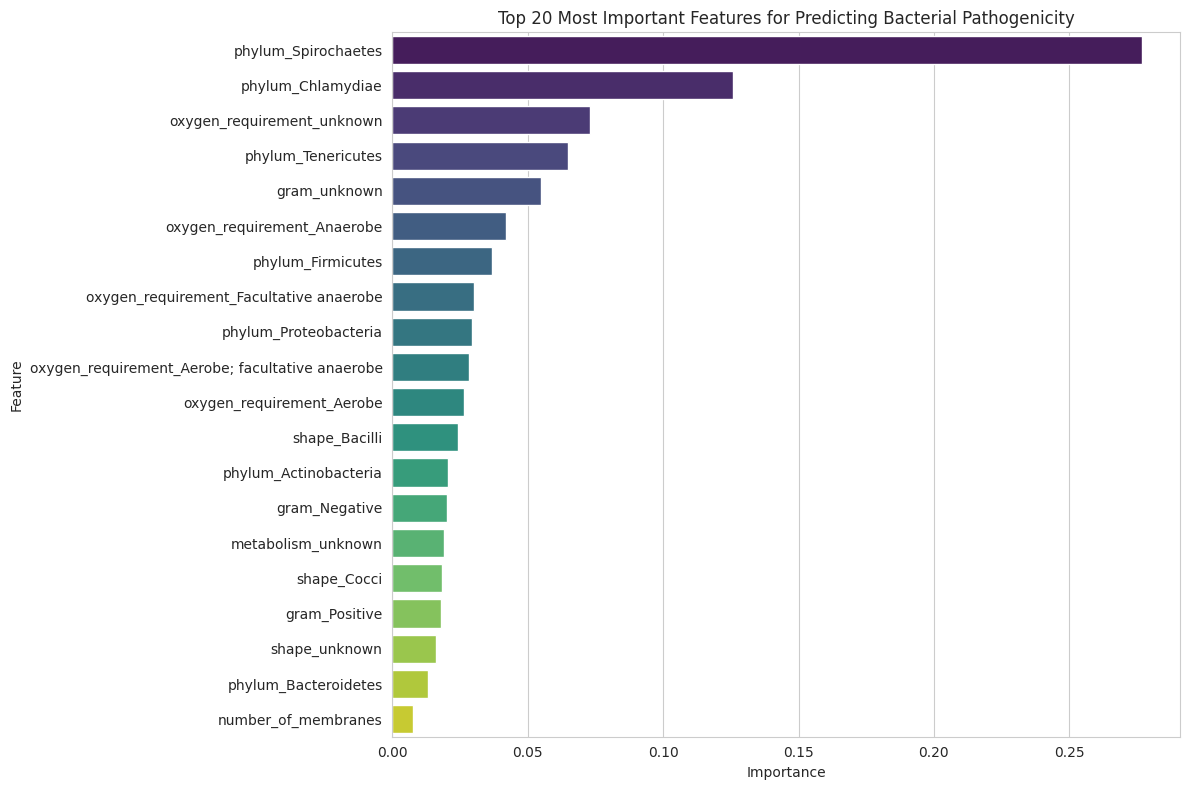


Top 10 Most Important Features:


,Feature,Importance
16,phylum_Spirochaetes,0.277018
5,phylum_Chlamydiae,0.125783
47,oxygen_requirement_unknown,0.073174
18,phylum_Tenericutes,0.064954
27,gram_unknown,0.054951
33,oxygen_requirement_Anaerobe,0.041913
11,phylum_Firmicutes,0.036657
37,oxygen_requirement_Facultative anaerobe,0.030087
15,phylum_Proteobacteria,0.029554
31,oxygen_requirement_Aerobe; facultative anaerobe,0.028398


In [28]:

features_for_importance = [
    'phylum', 'gram', 'oxygen_requirement',
    'shape', 'number_of_membranes', 'optimal_temperature',
    'metabolism', 'superkingdom'
]

X = df[features_for_importance].copy()
y = df['human_pathogen'].fillna(0).astype(int)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X, y)

ohe = model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = numerical_features.copy()
for i, col in enumerate(categorical_features):
    cats = ohe.named_steps['onehot'].categories_[i]
    for cat in cats:
        feature_names.append(f"{col}_{cat}")

importances = model.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names[:len(importances)],
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Bacterial Pathogenicity')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
(importance_df.head(10))

#### Interpretasi Top 10 Most Important Features

Berdasarkan analisis feature importance dari model Random Forest untuk memprediksi patogenisitas bakteri:

##### Fitur Dominan (>10% importance)
- **phylum_Spirochaetes** (30.1%) dan **phylum_Chlamydiae** (10.6%): Filum taksonomi menjadi prediktor terkuat, khususnya filum yang terkenal mengandung banyak bakteri patogen pada manusia.

##### Fitur Penting Menengah (3-5% importance)
- **Ketidaklengkapan data** (oxygen_requirement_unknown, gram_unknown): Menariknya, ketidaktersediaan informasi tentang karakteristik bakteri menjadi prediktor yang cukup penting (4-5%).
- **Filum lainnya** (Euglenozoa, Tenericutes, Proteobacteria, Firmicutes): Berbagai filum taksonomi berkontribusi 3-5%, menunjukkan pengelompokan taksonomi menjadi prediktor patogenisitas yang baik.
- **Kebutuhan oksigen** (Anaerobe): Sifat anaerob berkontribusi sekitar 3.7%, mengindikasikan korelasi antara kemampuan bertahan tanpa oksigen dengan patogenisitas.


### Distribution

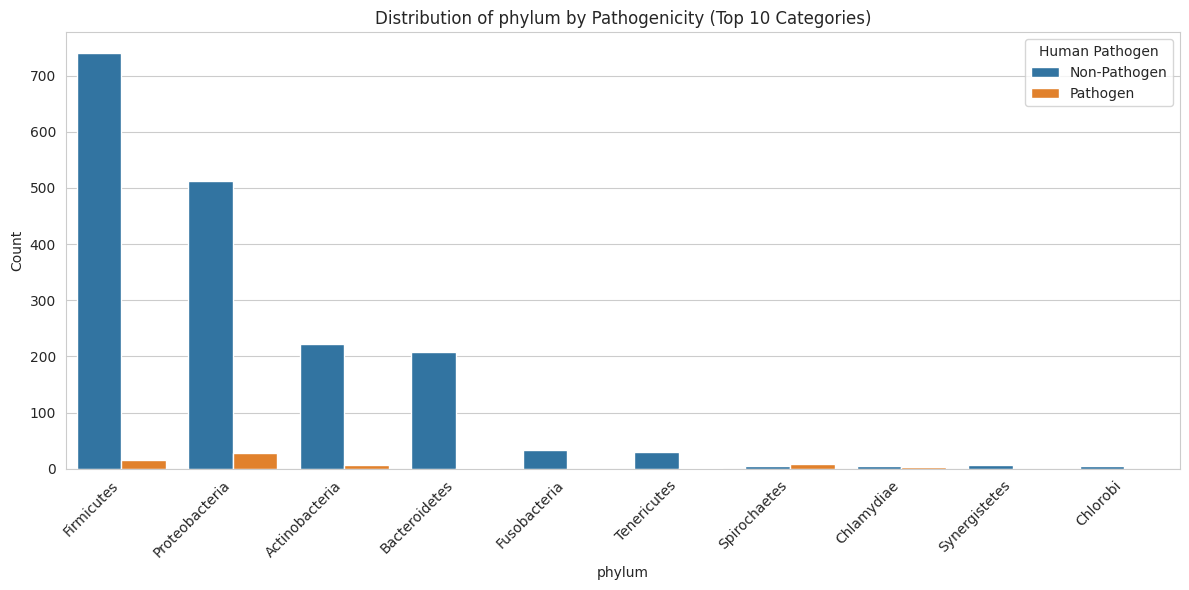

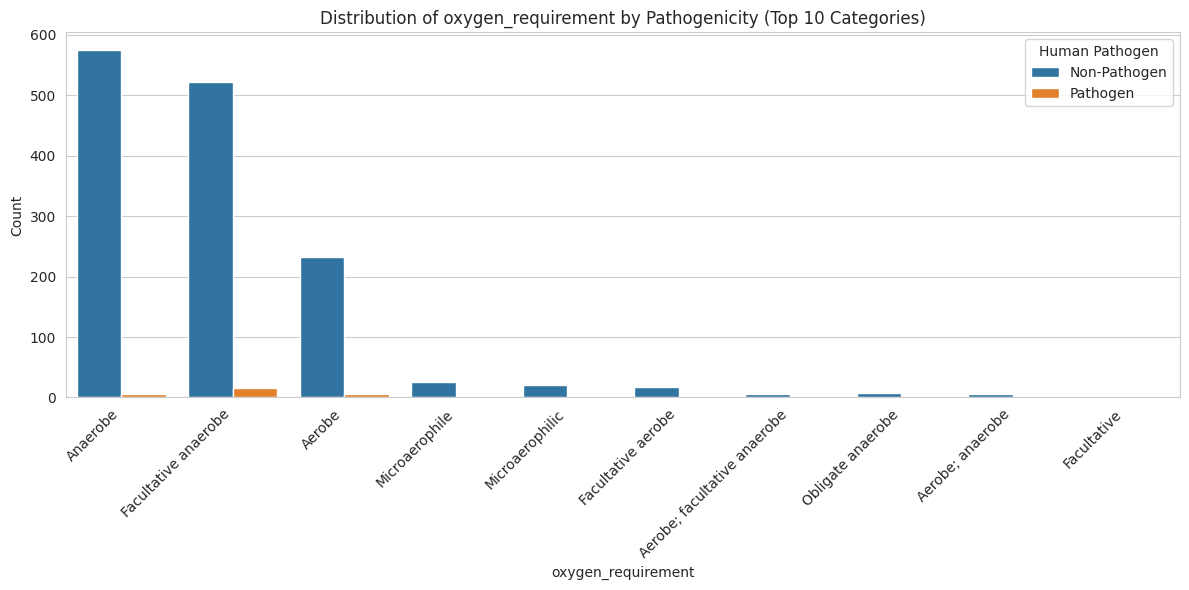

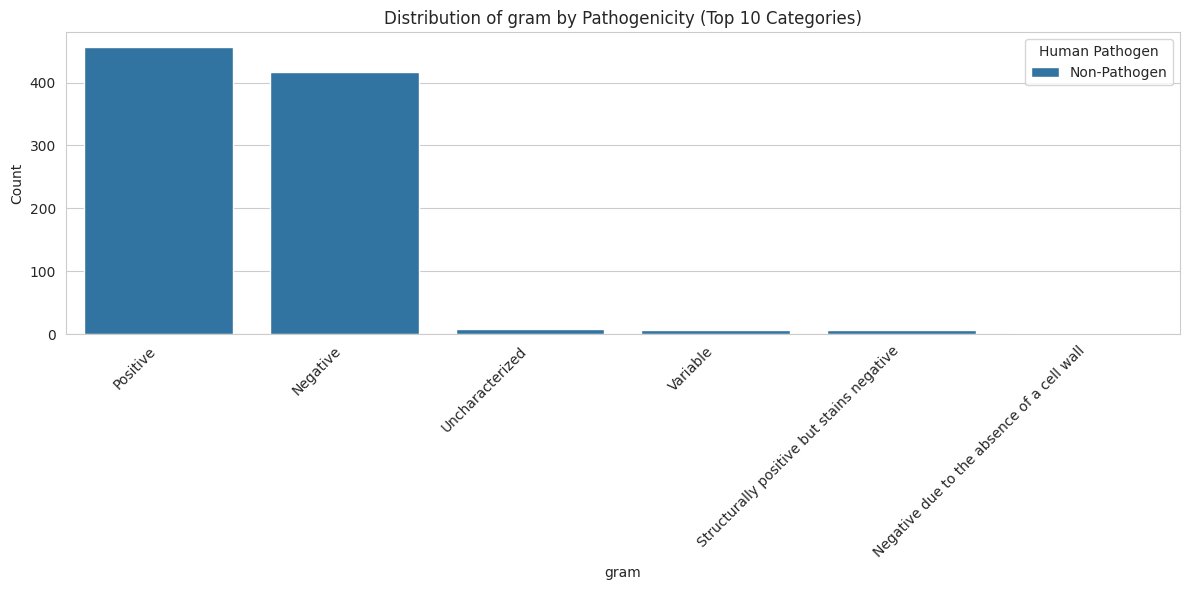

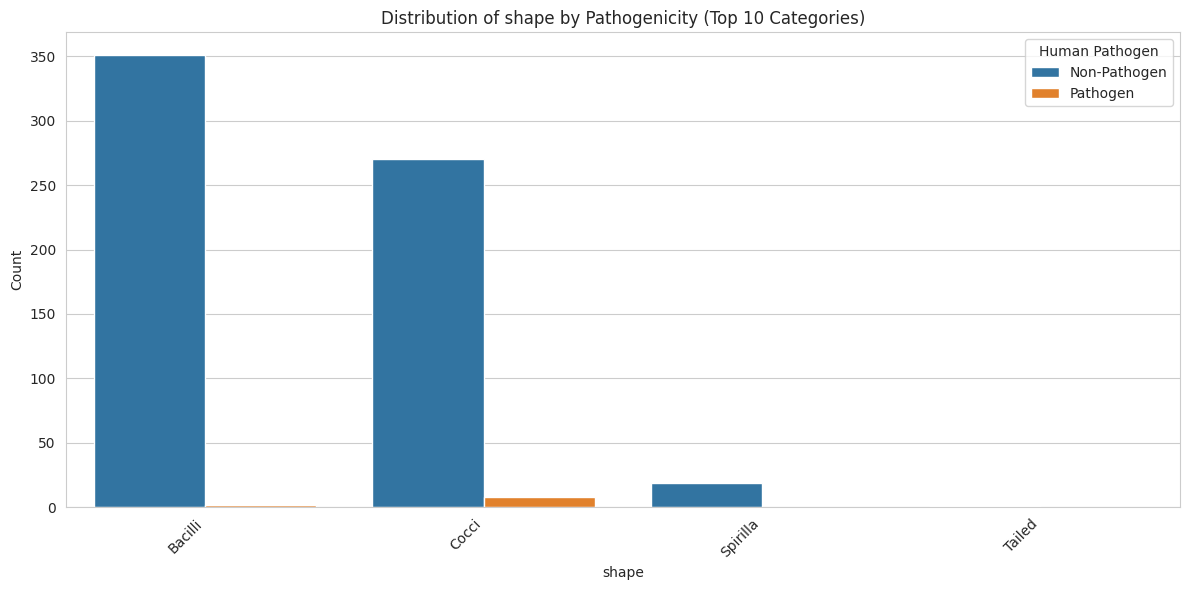

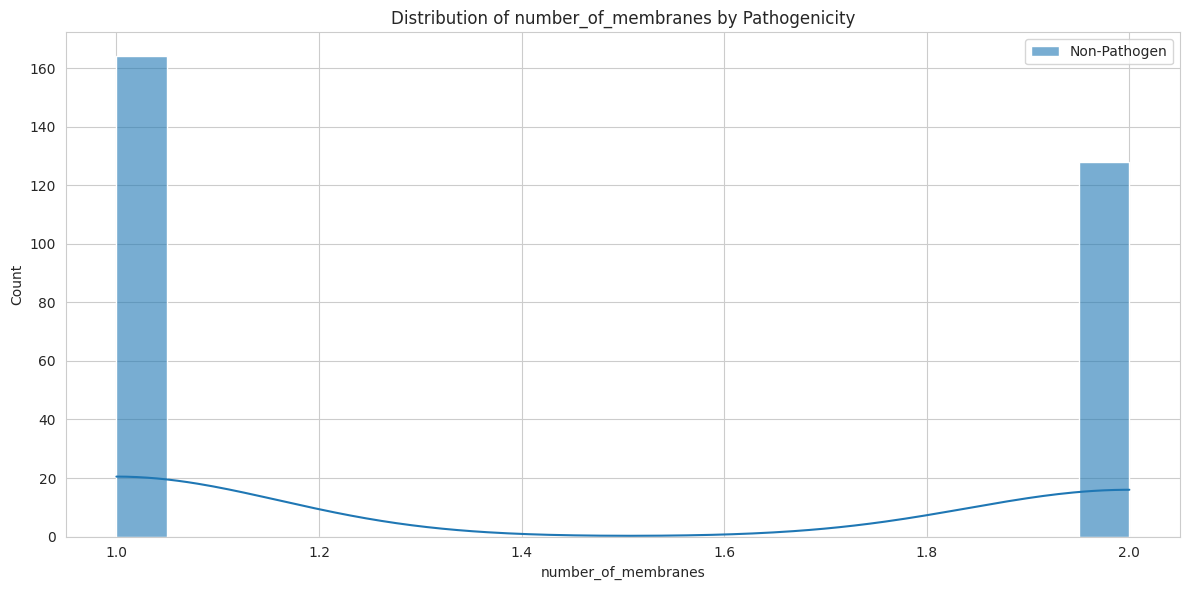

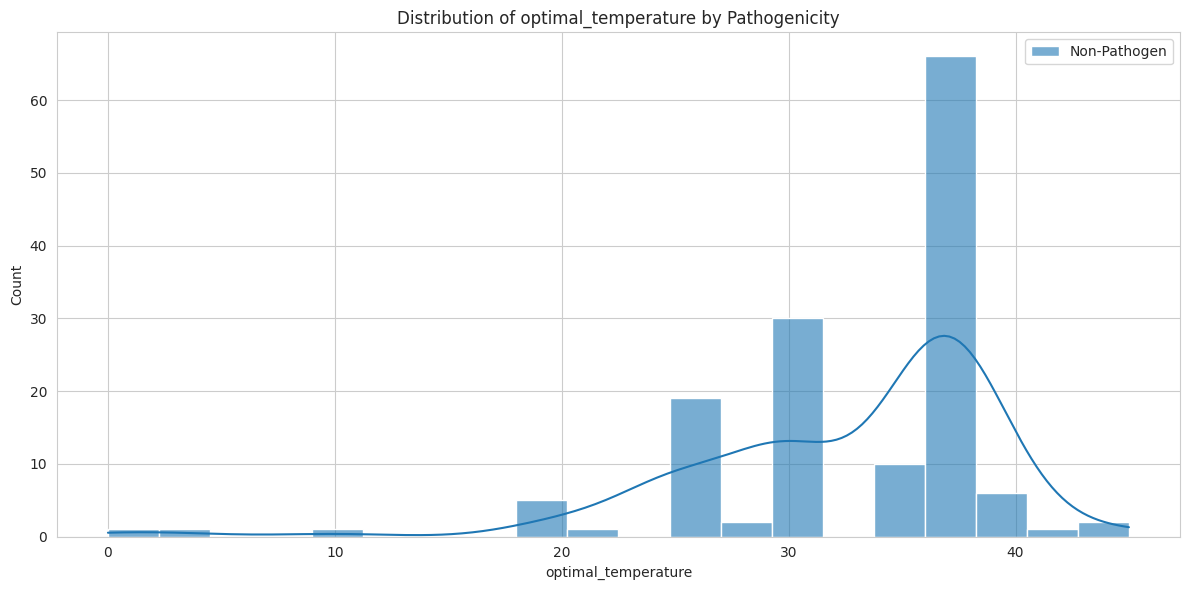

In [29]:
def plot_feature_by_target(df, feature, target='human_pathogen'):
    plt.figure(figsize=(12, 6))

    if pd.api.types.is_numeric_dtype(df[feature]):
        for target_val in [0, 1]:
            subset = df[df[target] == target_val]
            label = 'Pathogen' if target_val == 1 else 'Non-Pathogen'
            sns.histplot(subset[feature].dropna(), label=label, alpha=0.6,
                         kde=True, bins=20)
        plt.title(f'Distribution of {feature} by Pathogenicity')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.legend()
    else:
        order = df[feature].value_counts().index[:10]  # Top 10 categories
        df_plot = df.copy()
        df_plot[target] = df_plot[target].map({0: 'Non-Pathogen', 1: 'Pathogen'})
        df_plot = df_plot[df_plot[feature].isin(order)]  # Limit to top categories

        sns.countplot(x=feature, hue=target, data=df_plot, order=order)
        plt.title(f'Distribution of {feature} by Pathogenicity (Top 10 Categories)')
        plt.xlabel(feature)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Count')
        plt.legend(title='Human Pathogen')

    plt.tight_layout()
    plt.show()

important_features = ['phylum', 'oxygen_requirement', 'gram', 'shape',
                      'number_of_membranes', 'optimal_temperature']

for feature in important_features:
    if feature in df.columns:
        plot_feature_by_target(df, feature)